In [2]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl
import pandas as pd
import sys

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

In [3]:
paths = [
# #     r"C:\Users\Administrator\Code\qcodes_wp",
    r"C:\Users\jowat\OneDrive\BF1\Code",
    r"C:\Users\jowat\OneDrive\BF1\Code\Qcodes",
    r"C:\Users\jowat\OneDrive\BF1\Data"
]

for p in paths:
    if p not in sys.path:
        sys.path.append(p)

In [4]:
import qcodes as qc
from qcodes import load_by_id
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter


In [319]:
load_by_id?

In [5]:
from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.mplplots.init_nb_plotting import *

qc.config['core']['db_location'] = r"D:\OneDrive\BF2\Data\experiments.db"

In [5]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
def mob_fit(x, a, b, c):
    return 1/(a + b/(x-c))

In [6]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [7]:
e = 1.602e-19
h = 6.63e-34
2*e**2/h

7.74179185520362e-05

In [6]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

## Mobility fitting

In [84]:
dv1 = qc.load_by_id(251)
dv2 = qc.load_by_id(252)

<IPython.core.display.Javascript object>


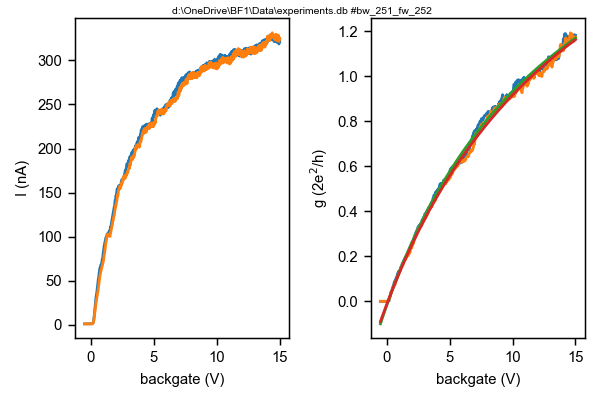

fw:  [  5.48030496e+03   8.26843217e+04   1.19651243e-01]
bw:  [  5.18909281e+03   8.81865226e+04   9.75163981e-02]


In [86]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i1_fw = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g1_fw = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac6"))[:,0] 
i1_bw = np.array(dv2.get_values('ivvi_setup_i1_measurement'))[:,0]
g1_bw = np.array(dv2.get_values('ivvi_setup_g1_measurement'))[:,0]

popt_fw, pcov_fw = curve_fit(mob_fit, bg_fw[20:], g1_fw[20:]*(2*e**2/h))
popt_bw, pcov_bw = curve_fit(mob_fit, bg_bw[:-20], g1_bw[:-20]*(2*e**2/h))

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i1_fw*1e9)
ax1.plot(bg_bw, i1_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g1_fw)
ax2.plot(bg_bw, g1_bw)
ax2.plot(bg_fw, mob_fit(bg_fw, *popt_fw)/(2*e**2/h))
ax2.plot(bg_bw, mob_fit(bg_bw, *popt_bw)/(2*e**2/h))
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()


print("fw: ", popt_fw)
print("bw: ", popt_bw)

<IPython.core.display.Javascript object>


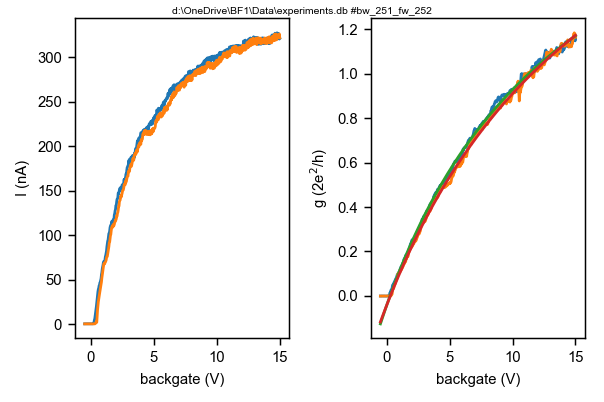

fw:  [  5.42486233e+03   8.25375162e+04   2.64734271e-01]
bw:  [  4.84431124e+03   9.06745301e+04   2.88938873e-01]


In [88]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i2_fw = np.array(dv1.get_values('ivvi_setup_i2_measurement'))[:,0]
g2_fw = np.array(dv1.get_values('ivvi_setup_g2_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac6"))[:,0] 
i2_bw = np.array(dv2.get_values('ivvi_setup_i2_measurement'))[:,0]
g2_bw = np.array(dv2.get_values('ivvi_setup_g2_measurement'))[:,0]

popt_fw, pcov_fw = curve_fit(mob_fit, bg_fw[20:], g2_fw[20:]*(2*e**2/h))
popt_bw, pcov_bw = curve_fit(mob_fit, bg_bw[:-20], g2_bw[:-20]*(2*e**2/h))

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i2_fw*1e9)
ax1.plot(bg_bw, i2_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g2_fw)
ax2.plot(bg_bw, g2_bw)
ax2.plot(bg_fw, mob_fit(bg_fw, *popt_fw)/(2*e**2/h))
ax2.plot(bg_bw, mob_fit(bg_bw, *popt_bw)/(2*e**2/h))
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()


print("fw: ", popt_fw)
print("bw: ", popt_bw)

<IPython.core.display.Javascript object>


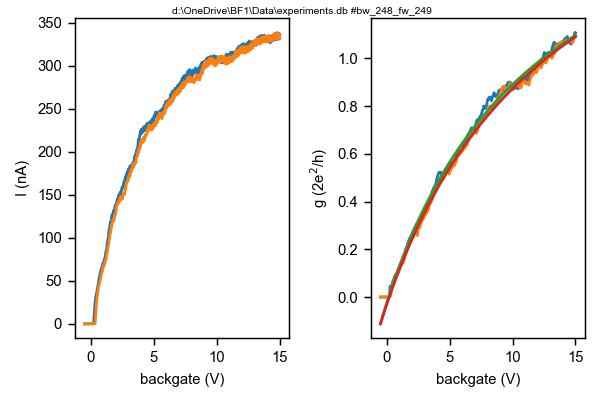

fw:  [  6.40018937e+03   7.97538116e+04   1.56876269e-01]
bw:  [  6.07810763e+03   8.53132443e+04   2.00602486e-01]


In [80]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i3_fw = np.array(dv1.get_values('ivvi_setup_i3_measurement'))[:,0]
g3_fw = np.array(dv1.get_values('ivvi_setup_g3_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac6"))[:,0] 
i3_bw = np.array(dv2.get_values('ivvi_setup_i3_measurement'))[:,0]
g3_bw = np.array(dv2.get_values('ivvi_setup_g3_measurement'))[:,0]

popt_fw, pcov_fw = curve_fit(mob_fit, bg_fw[20:], g3_fw[20:]*(2*e**2/h))
popt_bw, pcov_bw = curve_fit(mob_fit, bg_bw[:-20], g3_bw[:-20]*(2*e**2/h))

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i3_fw*1e9)
ax1.plot(bg_bw, i3_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g3_fw)
ax2.plot(bg_bw, g3_bw)
ax2.plot(bg_fw, mob_fit(bg_fw, *popt_fw)/(2*e**2/h))
ax2.plot(bg_bw, mob_fit(bg_bw, *popt_bw)/(2*e**2/h))
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()


print("fw: ", popt_fw)
print("bw: ", popt_bw)

In [108]:
L = 3e-6
C = 95e-18
a = np.array([9.62535231e04, 1.03273886e05,  8.39500765e04, 8.69609239e04, 8.21812594e04, 8.56998420e04, 8.102e4, 8.357e4, 8.948e4, 9.144e4, 7.975e4, 8.531e4, 8.26843217e+04, 8.81865226e+04,  8.25375162e+04, 9.06745301e+04])

mu = L**2/(a*C)

print(mu)

[ 0.98424285  0.91733589  1.12849024  1.08941853  1.15277915  1.10544944
  1.16930193  1.13362262  1.05874879  1.0360547   1.18792279  1.11050102
  1.14576549  1.07427801  1.1478034   1.04480103]


## Pinchoff curve overlays

In [73]:
dv1 = qc.load_by_id(40)
dv2 = qc.load_by_id(41)
dv1
dv2

results #41@D:\OneDrive\BF2\Data\experiments.db
-----------------------------------------------
ivvi_setup_dac3 - numeric
ivvi_setup_i1_measurement - numeric
ivvi_setup_i2_measurement - numeric
ivvi_setup_i3_measurement - numeric
ivvi_setup_g1_measurement - numeric
ivvi_setup_g2_measurement - numeric
ivvi_setup_g3_measurement - numeric

<IPython.core.display.Javascript object>


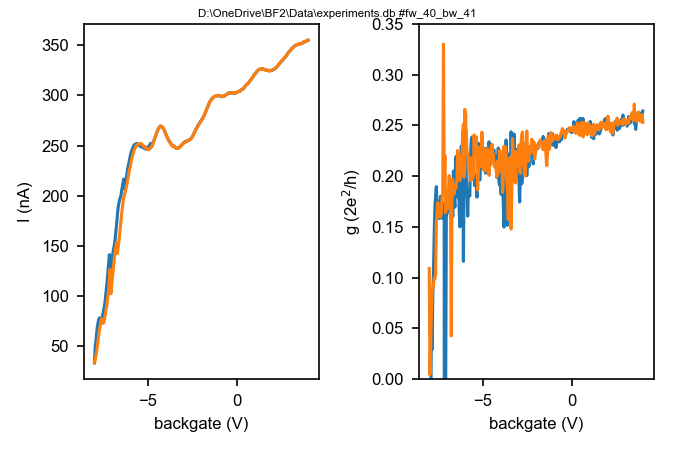

In [74]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac3"))[:,0] 
i_fw = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g_fw = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac3"))[:,0] 
i_bw = np.array(dv2.get_values('ivvi_setup_i1_measurement'))[:,0]
g_bw = np.array(dv2.get_values('ivvi_setup_g1_measurement'))[:,0]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i_fw*1e9)
ax1.plot(bg_bw, i_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g_fw)
ax2.plot(bg_bw, g_bw)
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')
#ax2.set_xlim([-4, 0])
ax2.set_ylim([0,0.35])

fig.suptitle(ds_title("fw_" + str(dv1.run_id) + "_bw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()

<IPython.core.display.Javascript object>


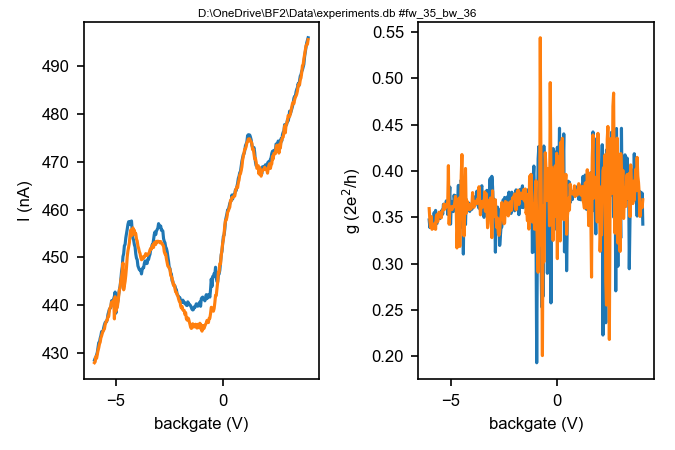

In [72]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac3"))[:,0] 
i_fw = np.array(dv1.get_values('ivvi_setup_i2_measurement'))[:,0]
g_fw = np.array(dv1.get_values('ivvi_setup_g2_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac3"))[:,0] 
i_bw = np.array(dv2.get_values('ivvi_setup_i2_measurement'))[:,0]
g_bw = np.array(dv2.get_values('ivvi_setup_g2_measurement'))[:,0]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i_fw*1e9)
ax1.plot(bg_bw, i_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g_fw)
ax2.plot(bg_bw, g_bw)
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')
#ax2.set_xlim([-10, -8])
# ax2.set_ylim([0,2])

fig.suptitle(ds_title("fw_" + str(dv1.run_id) + "_bw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()

<IPython.core.display.Javascript object>


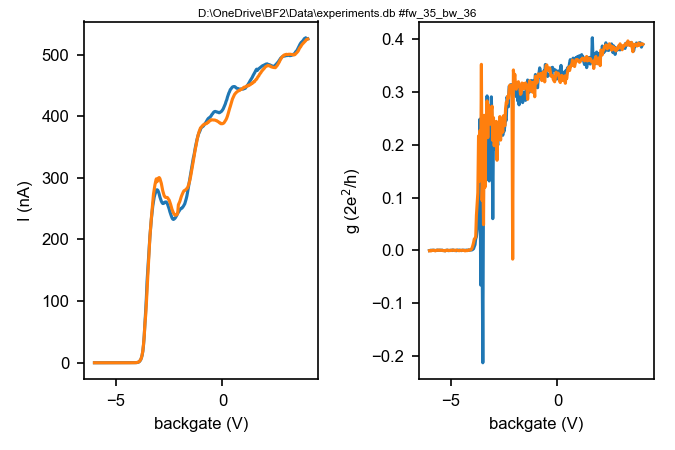

In [68]:
bg_fw = np.array(dv1.get_data("ivvi_setup_dac3"))[:,0] 
i_fw = np.array(dv1.get_values('ivvi_setup_i3_measurement'))[:,0]
g_fw = np.array(dv1.get_values('ivvi_setup_g3_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac3"))[:,0] 
i_bw = np.array(dv2.get_values('ivvi_setup_i3_measurement'))[:,0]
g_bw = np.array(dv2.get_values('ivvi_setup_g3_measurement'))[:,0]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i_fw*1e9)
ax1.plot(bg_bw, i_bw*1e9)
ax1.set_xlabel('backgate (V)')
ax1.set_ylabel('I (nA)')

ax2.plot(bg_fw, g_fw)
ax2.plot(bg_bw, g_bw)
ax2.set_xlabel('backgate (V)')
ax2.set_ylabel(r'g (2e$^2$/h)')
#ax2.set_ylim([0,10])

fig.suptitle(ds_title("fw_" + str(dv1.run_id) + "_bw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()

## 2D plotting plus linecuts

In [428]:
dv1 = qc.load_by_id(235)
dv1

results #235@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
yoko_voltage - numeric
ivvi_setup_dac3 - numeric
ivvi_setup_g1_measurement - numeric
ivvi_setup_g2_measurement - numeric
ivvi_setup_g3_measurement - numeric
lockin1_X - numeric
lockin2_X - numeric
lockin3_X - numeric

<IPython.core.display.Javascript object>


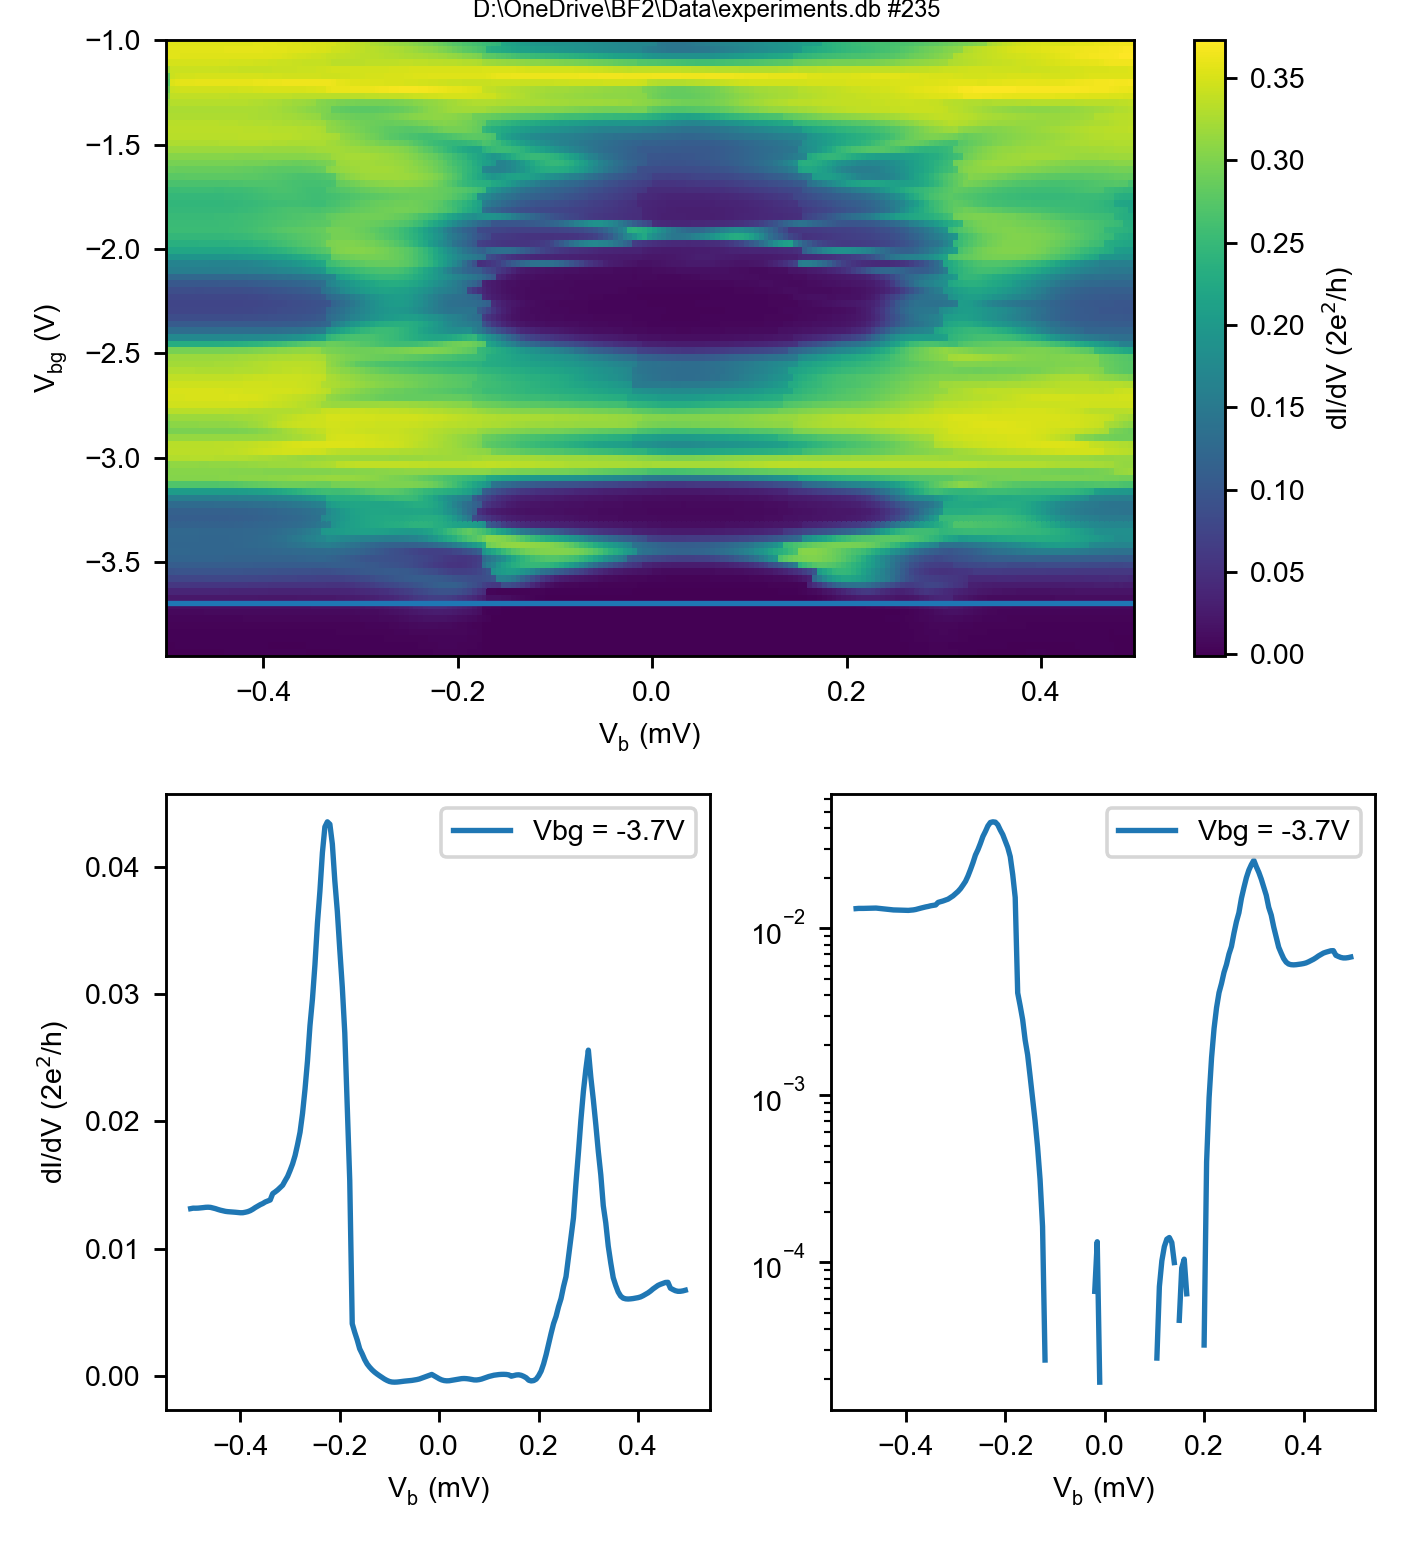

In [431]:
dv1 = qc.load_by_id(235)

bg = np.array(dv1.get_data("ivvi_setup_dac3"))[:,0] 
bias = np.array(dv1.get_data("yoko_voltage"))[:,0] 
# i = np.array(dv1.get_values('ivvi_setup_i3_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]



bg = np.unique(bg)
bg = np.flip(bg, 0)
bias= np.unique(bias)

n_lines = bg.size - 1
g = g[0:n_lines*bias.size]

g = g.reshape(n_lines, bias.size)
g = g - .0003
    

fig = plt.figure(figsize=(5.5,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

bg_cut = -3.7
bg_cut_idx = np.argmin(abs(bg - bg_cut))
n_cut = 40


# p = ax1.pcolor(bias*1e3, bg[0:n_lines], g)#, vmin=0, vmax=0.25)
p = ax1.pcolor(bias[idx1:idx2]*1e3, bg[idx3:idx4], g[idx3:idx4, idx1:idx2])#, vmin=0, vmax=0.25)
ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')


# ax2.plot(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.plot(bias[idx1:idx2]*1e3, g[bg_cut_idx,idx1:idx2], label='Vbg = ' + str(bg_cut) + 'V')
ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax3.semilogy(bias[idx1:idx2]*1e3, g[bg_cut_idx,idx1:idx2], label='Vbg = ' + str(bg_cut) + 'V')
ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

# fig.savefig("d:/data/images/gap_dev14.png", dpi=300)

In [430]:
idx1 = np.argmin(abs(bias + 0.5e-3))
idx2 = np.argmin(abs(bias - 0.5e-3))
idx3 = np.argmin(abs(bg + 1))
idx4 = np.argmin(abs(bg + 4))

## Bias vs theta scans

In [29]:
dv1 = qc.load_by_id(251)
dv1

results #251@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
yoko_voltage - numeric
AMI430_theta - numeric
ivvi_setup_g1_measurement - numeric
ivvi_setup_g2_measurement - numeric
ivvi_setup_g3_measurement - numeric

<IPython.core.display.Javascript object>


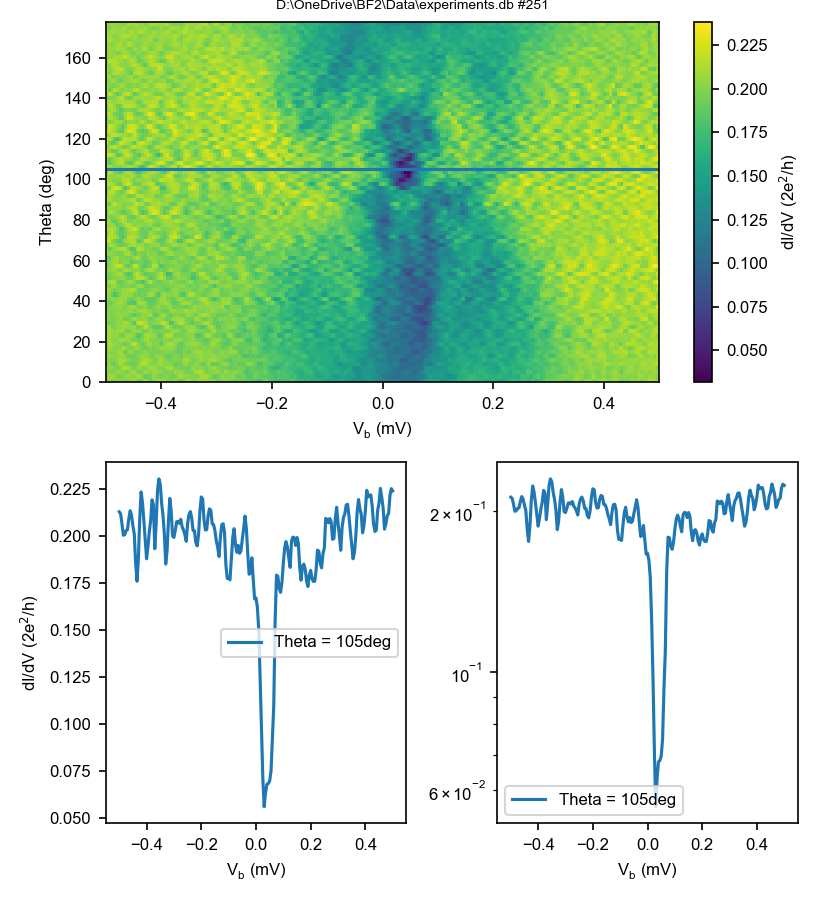

In [34]:
dv1 = qc.load_by_id(251)

theta = np.array(dv1.get_data("AMI430_theta"))[:,0] 
bias = np.array(dv1.get_data("yoko_voltage"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g2_measurement'))[:,0]



theta = np.unique(theta)
#theta = np.flip(theta, 0)
bias= np.unique(bias)

n_lines = theta.size - 1
g = g[0:n_lines*bias.size]

g = g.reshape(n_lines, bias.size)
g = g + .0015

fig = plt.figure(figsize=(5.5,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

theta_cut = 105
theta_cut_idx = np.argmin(abs(theta - theta_cut))
n_cut = 40


# p = ax1.pcolor(bias*1e3, bg[0:n_lines], g)#, vmin=0, vmax=0.3)
# ax1.axhline(y=bg_cut)
# ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
# ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')

p = ax1.pcolor(bias*1e3, theta[0:n_lines], g)#, vmin=0, vmax=0.3)
ax1.axhline(y=theta_cut)
ax1.set_ylabel(r"Theta (deg)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')


ax2.plot(bias*1e3, g[theta_cut_idx,:], label='Theta = ' + str(theta_cut) + 'deg')
ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

ax3.semilogy(bias*1e3, g[theta_cut_idx,:], label='Theta = ' + str(theta_cut) + 'deg')
ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

## Bias vs Br scans


In [389]:
dv1 = qc.load_by_id(345)
dv1

results #345@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
v_g - numeric
i_avg - numeric
AMI430_field - numeric
v_sd_1 - numeric
v_sd_2 - numeric
v_sd_3 - numeric

<IPython.core.display.Javascript object>


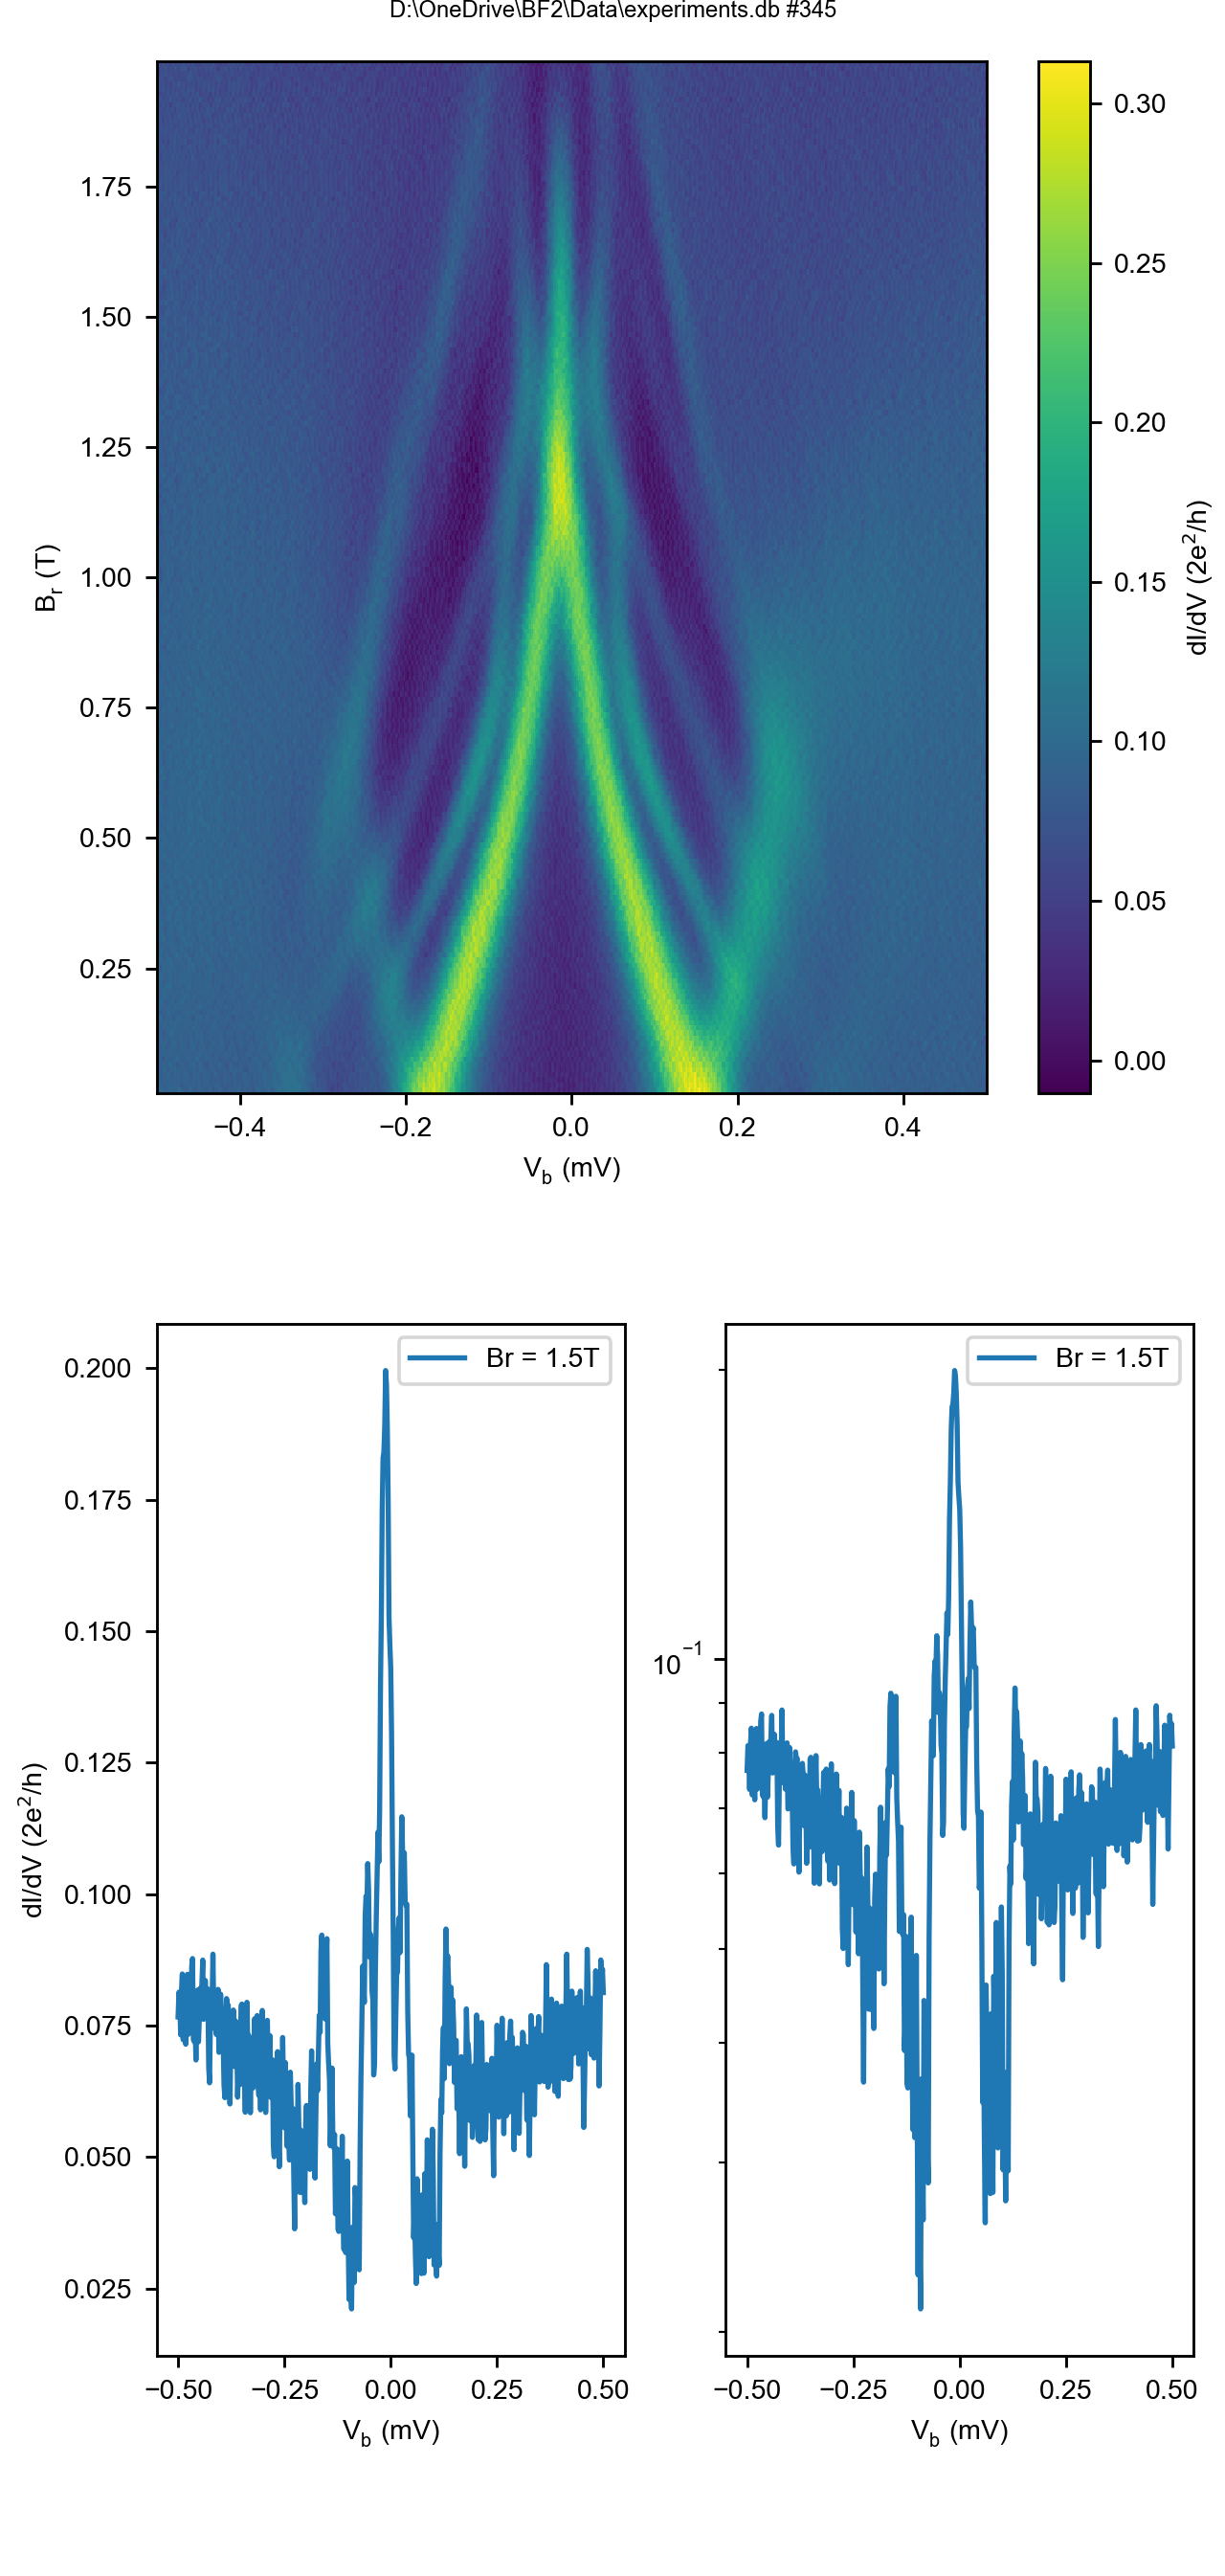

In [394]:
dv1 = qc.load_by_id(345)

Br = np.array(dv1.get_data("AMI430_field"))[:,0] 
bias = np.array(dv1.get_data("v_g"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('v_sd_1'))[:,0]



Br = np.unique(Br)
Br = np.flip(Br, 0)
bias= 2*np.unique(bias)/100

n_lines = Br.size - 1
g = g[0:n_lines*bias.size]

g = g.reshape(n_lines, bias.size)
g = g + .0015

fig = plt.figure(figsize=(5.5,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

Br_cut = 1.5
Br_cut_idx = np.argmin(abs(Br - Br_cut))
n_cut = 40


# p = ax1.pcolor(bias*1e3, bg[0:n_lines], g)#, vmin=0, vmax=0.3)
# ax1.axhline(y=bg_cut)
# ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
# ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')

p = ax1.pcolor(bias*1e3, Br[0:n_lines], g)#, vmin=0, vmax=0.03)
ax1.axhline(y=Br_cut)
ax1.set_ylabel(r"$\mathregular{B_{r}}$ (T)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')


ax2.plot(bias*1e3, g[Br_cut_idx,:], label='Br = ' + str(Br_cut) + 'T')
ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

ax3.semilogy(bias*1e3, g[Br_cut_idx,:], label='Br = ' + str(Br_cut) + 'T')
ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

### Hardware sweep variety

In [172]:
dv1 = qc.load_by_id(345)
dv1

results #345@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
v_g - numeric
i_avg - numeric
AMI430_field - numeric
v_sd_1 - numeric
v_sd_2 - numeric
v_sd_3 - numeric

In [137]:
Br = np.array(dv1.get_data("AMI430_field"))[:,0] 
bias = np.array(dv1.get_data("v_g"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('v_sd_1'))[:,0]

In [138]:
np.shape(g)[0]/501

200.0

In [139]:
Br = np.linspace(1.99, 0, 200)

In [140]:
Br[1]

1.98

<IPython.core.display.Javascript object>


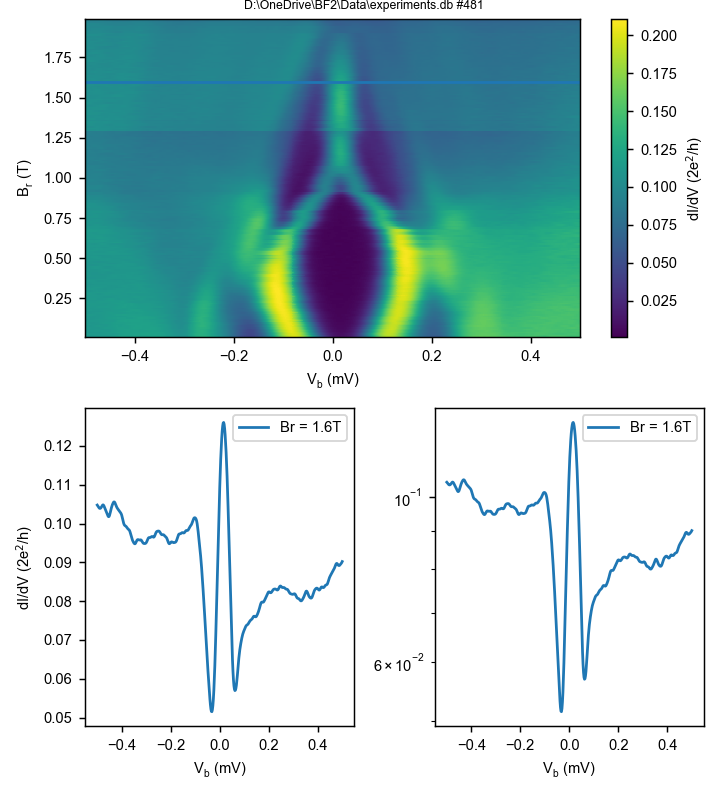

In [289]:
dv1 = qc.load_by_id(481)

Br = np.array(dv1.get_data("AMI430_field"))[:,0] 
bias = np.array(dv1.get_data("v_g"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('v_sd_3'))[:,0]



Br = np.unique(Br)
Br = np.flip(Br, 0)
bias= np.unique(bias)*2/100

n_lines = Br.size - 1
g = g[0:n_lines*bias.size]

g = g.reshape(n_lines, bias.size)
g = g + .0015

fig = plt.figure(figsize=(5.5,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

Br_cut = 1.6
Br_cut_idx = np.argmin(abs(Br - Br_cut))
n_cut = 40


# p = ax1.pcolor(bias*1e3, bg[0:n_lines], g)#, vmin=0, vmax=0.3)
# ax1.axhline(y=bg_cut)
# ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
# ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')

p = ax1.pcolor(bias*1e3, Br[0:n_lines], g)#, vmin=0, vmax=0.03)
ax1.axhline(y=Br_cut)
ax1.set_ylabel(r"$\mathregular{B_{r}}$ (T)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')


ax2.plot(bias*1e3, g[Br_cut_idx,:], label='Br = ' + str(Br_cut) + 'T')
ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

ax3.semilogy(bias*1e3, g[Br_cut_idx,:], label='Br = ' + str(Br_cut) + 'T')
ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

## Gate vs gate scans

In [238]:
dv1 = qc.load_by_id(91
dv1

results #78@D:\OneDrive\BF2\Data\experiments.db
-----------------------------------------------
ivvi_dac5 - numeric
ivvi_dac4 - numeric
ivvi_setup_i1_measurement - numeric
ivvi_setup_g1_measurement - numeric

In [398]:
def smartgate2(pt1, pt2, x0, y0, x1, x2):
    m = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
    b = -m*pt1[0] + pt1[1]
    
    b1 = -m*x0 + y0
    y1 = x1*m + b1
    y2 = x2*m + b1
    return y1, y2

def smartgate3(pt1, pt2, x0, y0, x1, x2, perp=False):
    m = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
    b = -m*pt1[0] + pt1[1]
    
    b1 = -m*x0 + y0
    y1 = x1*m + b1
    y2 = x2*m + b1
    
    if perp:
        m_perp = -1/m
        b_perp = y0 + x0/m
        y1 = x1*m_perp + b_perp
        y2 = x2*m_perp +b_perp
    return y1, y2

In [400]:
dv1 = qc.load_by_id(311)
dv1

results #311@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
ivvi_dac5 - numeric
ivvi_dac4 - numeric
ivvi_setup_g1_measurement - numeric

<IPython.core.display.Javascript object>


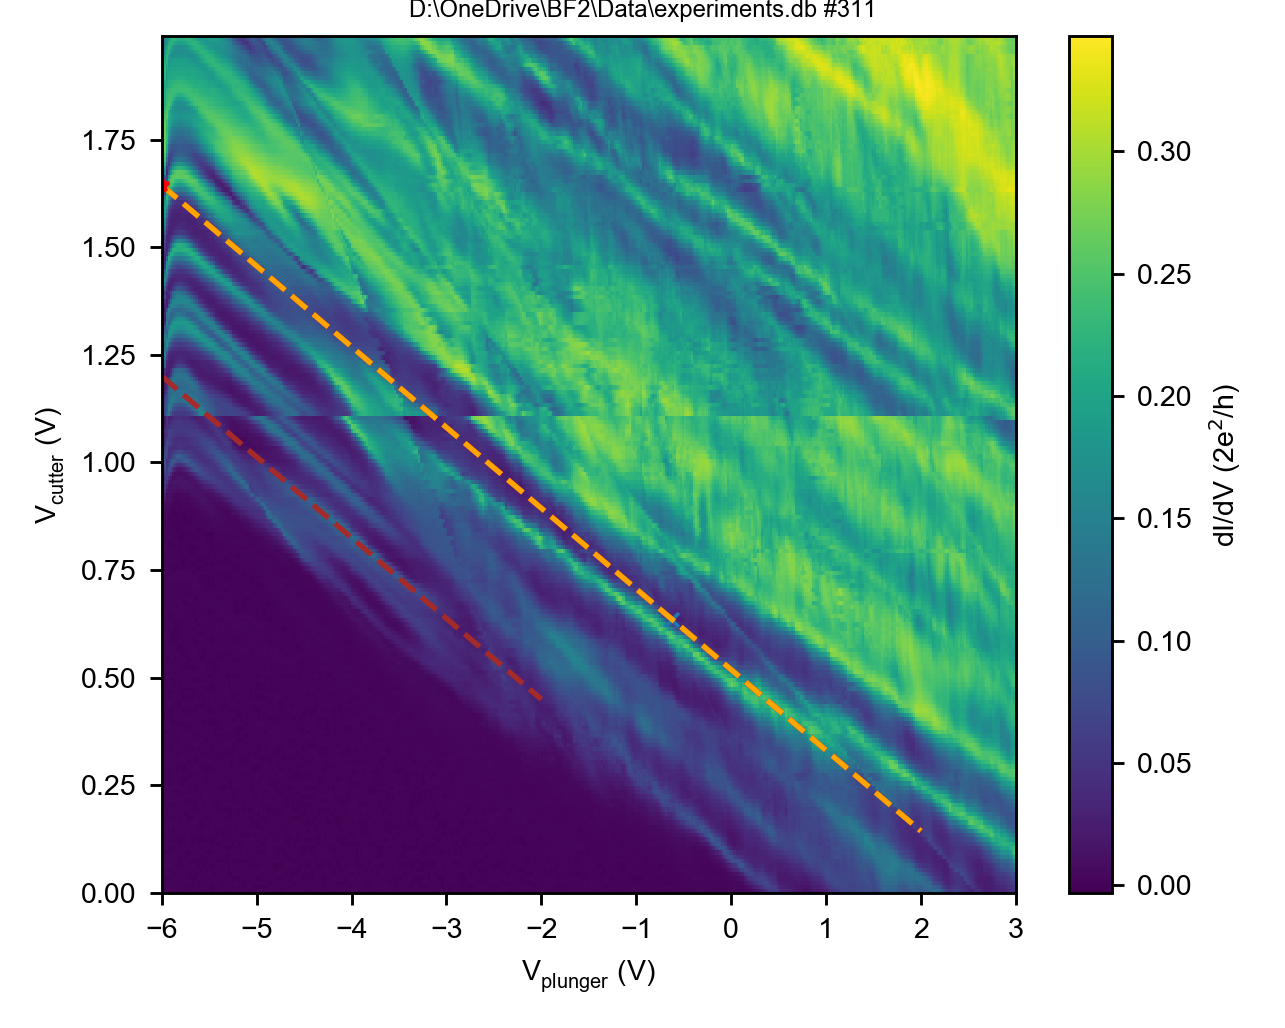

DAC values for field scan: (-6.0, 1.64375)


In [405]:
dv1 = qc.load_by_id(311)

cutter_scale = 5.0/1000
plunger_scale = 5.0/1000
mu_sweep_overlay = True
pt1 = [-1200, 240]
pt2 = [-400, 90]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
plunger_of_interest = -1200

cutter = np.array(dv1.get_data("ivvi_dac4"))[:,0] 
plunger = np.array(dv1.get_data("ivvi_dac5"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]


cutter = cutter_scale*np.unique(cutter)
#cutter = np.flip(cutter, 0)
plunger= plunger_scale*np.unique(plunger)
#plunger = np.flip(plunger, 0)

n_lines = cutter.size - 1
g = g[0:n_lines*plunger.size]

g = g.reshape(n_lines, plunger.size)
#g = g - .0003


fig, ax1 = plt.subplots(1,1, figsize=(5,4))


# cutter_cut = 0.55
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40


p = ax1.pcolor(plunger, cutter[0:n_lines], g)#, vmin=0, vmax=0.15)
#ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{cutter}}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_{plunger}}$ (V)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')

if mu_sweep_overlay:
    ax1.plot(np.linspace(pt1[0], pt2[0], 100)*plunger_scale, np.linspace(pt1[1], pt2[1], 100)*cutter_scale, '--', color='brown')
    cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend)
    cutterstart_perp, cutterend_perp = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
    cuttervals = np.linspace(cutterstart, cutterend, 101)*cutter_scale
    cuttervals_perp = np.linspace(cutterstart_perp, cutterend_perp, 101)*cutter_scale
    plungervals = np.linspace(plungerstart, plungerend, 101)*plunger_scale
    ax1.plot(plungervals, cuttervals, '--', color='red')
    ax1.plot(x0*plunger_scale,y0*cutter_scale,'x')
    ax1.plot(plungervals, cuttervals_perp, '--', color='orange')
    
    cutter_of_interest_idx = np.argmin(abs(plungervals - plunger_of_interest*plunger_scale))
    cutter_of_interest = cuttervals[cutter_of_interest_idx]
    ax1.plot(plunger_of_interest*plunger_scale, cutter_of_interest, '*', color='red')
    print('DAC values for field scan: (' + str(plunger_of_interest*plunger_scale) + ', ' + str(cutter_of_interest) + ')')

# ax2.plot(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
# ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax2.legend()
# # ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

<IPython.core.display.Javascript object>


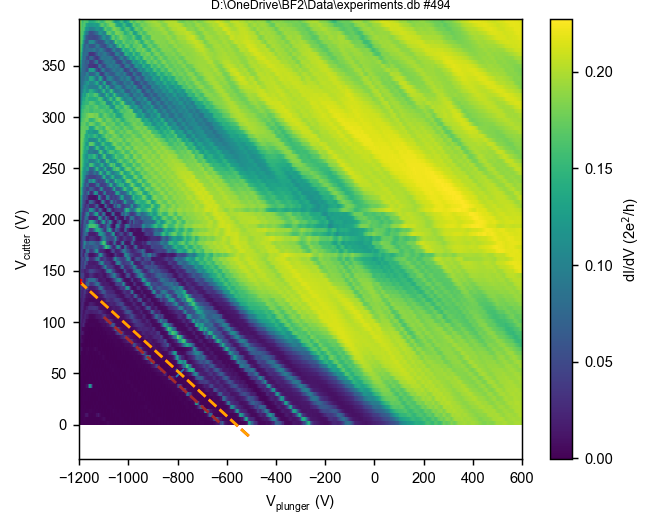

DAC values for field scan: (-1200, 139.6875)


In [314]:
dv1 = qc.load_by_id(494)

cutter_scale = 1#5.0/1000
plunger_scale = 1#5.0/1000
mu_sweep_overlay = True
pt1 = [-1100, 105]
pt2 = [-620, 0]
x0 = -790
y0 = 50
plungerstart = -1200
plungerend = -500
perp = False
plunger_of_interest = -1200

cutter = np.array(dv1.get_data("ivvi_dac6"))[:,0] 
plunger = np.array(dv1.get_data("ivvi_dac7"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g2_measurement'))[:,0]


cutter = cutter_scale*np.unique(cutter)
#cutter = np.flip(cutter, 0)
plunger= plunger_scale*np.unique(plunger)
#plunger = np.flip(plunger, 0)

n_lines = cutter.size - 1
g = g[0:n_lines*plunger.size]

g = g.reshape(n_lines, plunger.size)
#g = g - .0003


fig, ax1 = plt.subplots(1,1, figsize=(5,4))


# cutter_cut = 0.55
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40


p = ax1.pcolor(plunger, cutter[0:n_lines], g)#, vmin=0, vmax=0.15)
#ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{cutter}}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_{plunger}}$ (V)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')

if mu_sweep_overlay:
    ax1.plot(np.linspace(pt1[0], pt2[0], 100)*plunger_scale, np.linspace(pt1[1], pt2[1], 100)*cutter_scale, '--', color='brown')
    cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend)
    cutterstart_perp, cutterend_perp = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
    cuttervals = np.linspace(cutterstart, cutterend, 101)*cutter_scale
    cuttervals_perp = np.linspace(cutterstart_perp, cutterend_perp, 101)*cutter_scale
    plungervals = np.linspace(plungerstart, plungerend, 101)*plunger_scale
    ax1.plot(plungervals, cuttervals, '--', color='red')
    ax1.plot(x0*plunger_scale,y0*cutter_scale,'x')
    ax1.plot(plungervals, cuttervals_perp, '--', color='orange')
    
    cutter_of_interest_idx = np.argmin(abs(plungervals - plunger_of_interest*plunger_scale))
    cutter_of_interest = cuttervals[cutter_of_interest_idx]
    ax1.plot(plunger_of_interest*plunger_scale, cutter_of_interest, '*', color='red')
    print('DAC values for field scan: (' + str(plunger_of_interest*plunger_scale) + ', ' + str(cutter_of_interest) + ')')

# ax2.plot(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
# ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax2.legend()
# # ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

## Bias vs side plunger

In [67]:
dv1 = qc.load_by_id(272)
dv1

results #272@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
ivvi_dac5 - numeric
yoko_voltage - numeric
ivvi_setup_g1_measurement - numeric

In [169]:
dv1 = qc.load_by_id(344)

plunger_scale = 5.0/1000

bias = np.array(dv1.get_data("yoko_voltage"))[:,0] 
plunger = np.array(dv1.get_data("ivvi_dac5"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]


bias = np.unique(bias)
#bg = np.flip(bg, 0)
plunger= plunger_scale*np.unique(plunger)
#plunger = np.flip(plunger,0)

n_lines = plunger.size - 1
g = g[0:n_lines*bias.size]

g = g.reshape(n_lines, bias.size)
#g = g - .0003


fig, ax1 = plt.subplots(1,1, figsize=(5,4))


# cutter_cut = 0.55
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40


p = ax1.pcolor(plunger[0:n_lines], bias/1e-3, g.transpose())#, vmin=0, vmax=0.03)
#ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{b}}$ (mV)")
ax1.set_xlabel(r"$\mathregular{V_{plunger}}$ (V)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')


# ax2.plot(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
# ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax2.legend()
# # ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

ERROR:root:Could not execute transaction, rolling back
Traceback (most recent call last):
  File "d:\code\qcodes\qcodes\dataset\sqlite_base.py", line 254, in atomic_transaction
    c = transaction(conn, sql, *args)
  File "d:\code\qcodes\qcodes\dataset\sqlite_base.py", line 233, in transaction
    c.execute(sql)
sqlite3.OperationalError: no such column: yoko_voltage


OperationalError: no such column: yoko_voltage

### Hardware ramp variety

In [395]:
dv1 = qc.load_by_id(343)
dv1

results #343@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
v_g - numeric
i_avg - numeric
ivvi_dac5 - numeric
v_sd_1 - numeric
v_sd_2 - numeric
v_sd_3 - numeric

<IPython.core.display.Javascript object>


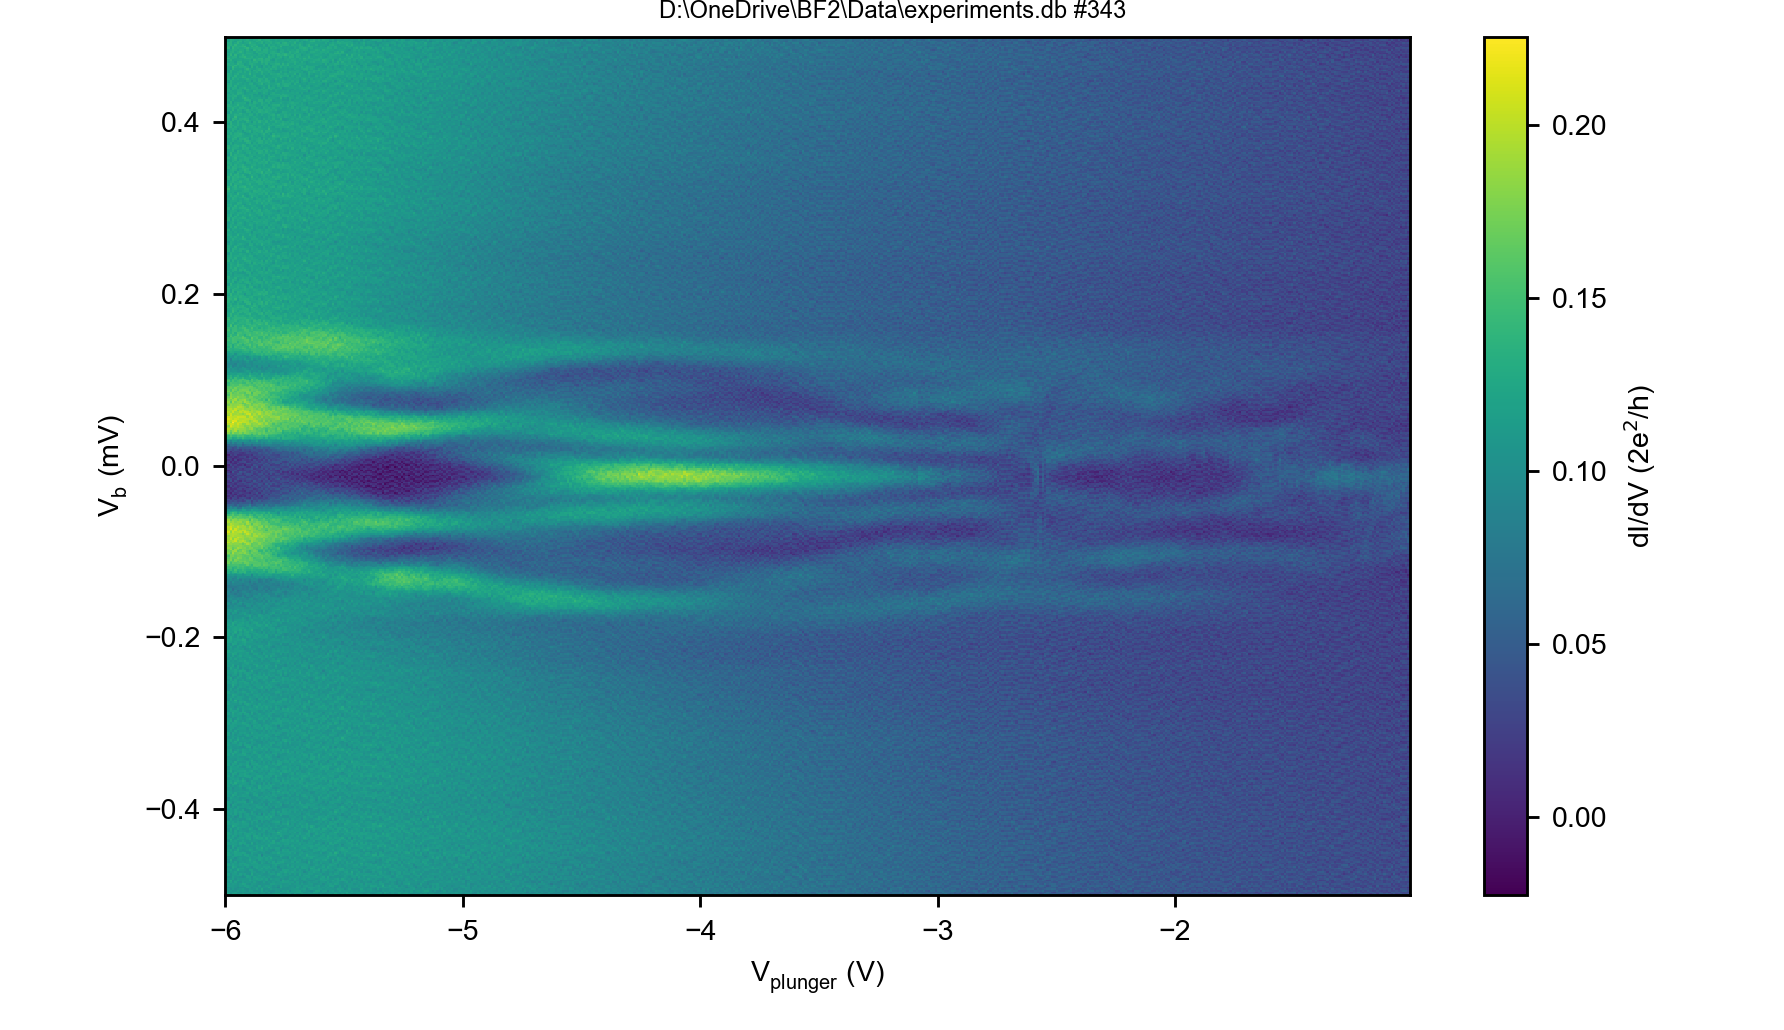

In [397]:
dv1 = qc.load_by_id(343)

plunger_scale = 5.0/1000

bias = np.array(dv1.get_data("v_g"))[:,0] 
plunger = np.array(dv1.get_data("ivvi_dac5"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('v_sd_1'))[:,0]


bias = np.unique(bias)*2/100
#bg = np.flip(bg, 0)
plunger= plunger_scale*np.unique(plunger)
#plunger = np.flip(plunger,0)

n_lines = plunger.size - 1
g = g[0:n_lines*bias.size]

g = g.reshape(n_lines, bias.size)
#g = g - .0003


fig, ax1 = plt.subplots(1,1, figsize=(5,4))


# cutter_cut = 0.55
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40


p = ax1.pcolor(plunger[0:n_lines], bias/1e-3, g.transpose())#, vmin=0, vmax=0.03)
#ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{b}}$ (mV)")
ax1.set_xlabel(r"$\mathregular{V_{plunger}}$ (V)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')


# ax2.plot(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
# ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax2.legend()
# # ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

<IPython.core.display.Javascript object>


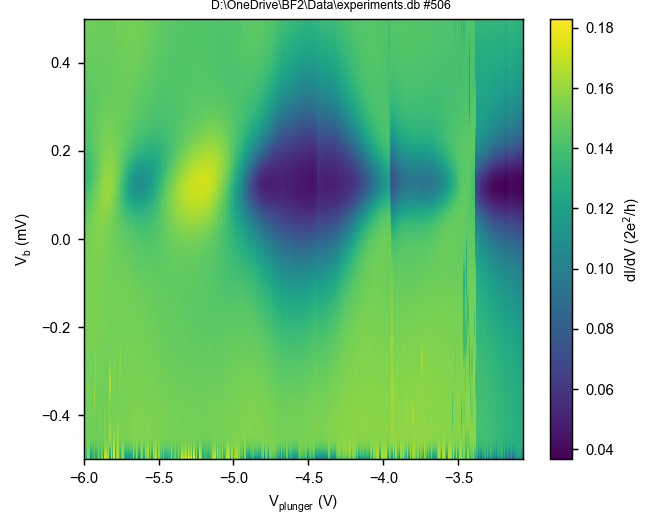

In [315]:
dv1 = qc.load_by_id(506)

plunger_scale = 5.0/1000

bias = np.array(dv1.get_data("v_g"))[:,0] 
plunger = np.array(dv1.get_data("ivvi_dac7"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('v_sd_2'))[:,0]


bias = np.unique(bias)*2/100
#bg = np.flip(bg, 0)
plunger= plunger_scale*np.unique(plunger)
#plunger = np.flip(plunger,0)

n_lines = plunger.size - 1
g = g[0:n_lines*bias.size]

g = g.reshape(n_lines, bias.size)
#g = g - .0003


fig, ax1 = plt.subplots(1,1, figsize=(5,4))


# cutter_cut = 0.55
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40


p = ax1.pcolor(plunger[0:n_lines], bias/1e-3, g.transpose())#, vmin=0, vmax=0.03)
#ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{b}}$ (mV)")
ax1.set_xlabel(r"$\mathregular{V_{plunger}}$ (V)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')


# ax2.plot(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
# ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax2.legend()
# # ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

## Numerical dV/dI - 2D plots

In [393]:
dv1 = qc.load_by_id(338)
dv1

results #338@d:/OneDrive/BF1/Data/experiments.db
------------------------------------------------
ivvi_setup_dac4 - numeric
ivvi_setup_dac6 - numeric
ivvi_setup_v1_measurement - numeric
ivvi_setup_v2_measurement - numeric
ivvi_setup_r_ac1_measurement - numeric
ivvi_setup_r_ac2_measurement - numeric

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


<IPython.core.display.Javascript object>


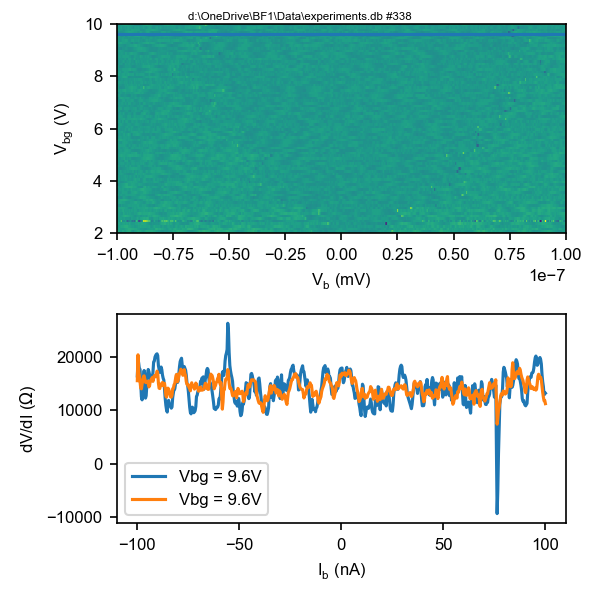

In [401]:
Nsmooth = 3 #Number of points to use for adjacent average smoothing 
bg = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
Ibias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
v = np.array(dv1.get_values('ivvi_setup_v1_measurement'))[:,0]
dvdi = np.array(dv1.get_values('ivvi_setup_r_ac2_measurement'))[:,0]



bg = np.unique(bg)
bg = np.flip(bg, 0)
Ibias= np.unique(Ibias)

n_lines = bg.size - 1
dvdi = dvdi[0:n_lines*Ibias.size]
dvdi = dvdi.reshape(n_lines, Ibias.size)

#pd.rolling_mean(x, N)[N-1:]
dvdi_smooth = pd.rolling_mean(dvdi, Nsmooth)[Nsmooth-1:]
fig = plt.figure(figsize=(4,4))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
#ax3 = plt.subplot(224)

bg_cut = 9.625
bg_cut_idx = np.argmin(abs(bg - bg_cut))
bg_cut = bg[bg_cut_idx]

p = ax1.pcolor(Ibias, bg[0:n_lines], dvdi)
ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")


ax2.plot(Ibias/1e-9, dvdi[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.plot(Ibias/1e-9, dvdi_smooth[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.set_ylabel(r'dV/dI ($\Omega$)')
ax2.set_xlabel(r"$\mathregular{I_b}$ (nA)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

#ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
#ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
#ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

# fig.savefig("d:/data/images/gap_dev14.png", dpi=300)

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


<IPython.core.display.Javascript object>


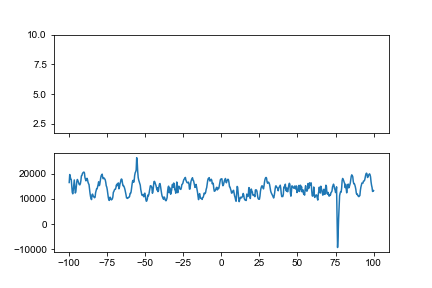

In [409]:
%matplotlib notebook
Nsmooth = 3 #Number of points to use for adjacent average smoothing 
bg = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
Ibias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
v = np.array(dv1.get_values('ivvi_setup_v1_measurement'))[:,0]
dvdi = np.array(dv1.get_values('ivvi_setup_r_ac2_measurement'))[:,0]



bg = np.unique(bg)
bg = np.flip(bg, 0)
Ibias= np.unique(Ibias)

n_lines = bg.size - 1
dvdi = dvdi[0:n_lines*Ibias.size]
dvdi = dvdi.reshape(n_lines, Ibias.size)

#pd.rolling_mean(x, N)[N-1:]
dvdi_smooth = pd.rolling_mean(dvdi, Nsmooth)[Nsmooth-1:]
#fig = plt.figure(figsize=(4,4))

#ax1 = plt.subplot(211)
#ax2 = plt.subplot(212)
#ax3 = plt.subplot(224)

bg_cut = 9.625
bg_cut_idx = np.argmin(abs(bg - bg_cut))
bg_cut = bg[bg_cut_idx]


#f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

#ax1.pcolormesh(Ibias, bg[0:n_lines], dvdi)
#ax2.plot(Ibias/1e-9, dvdi[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
#f.show()



# p = ax1.pcolor(Ibias, bg[0:n_lines], dvdi)
# ax1.axhline(y=bg_cut)
# ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
# ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")


# ax2.plot(Ibias/1e-9, dvdi[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.plot(Ibias/1e-9, dvdi_smooth[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.set_ylabel(r'dV/dI ($\Omega$)')
# ax2.set_xlabel(r"$\mathregular{I_b}$ (nA)")
# ax2.legend()
# # ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# #ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# #ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# #ax3.legend()

# fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
# fig.tight_layout()

# # fig.savefig("d:/data/images/gap_dev14.png", dpi=300)

<IPython.core.display.Javascript object>


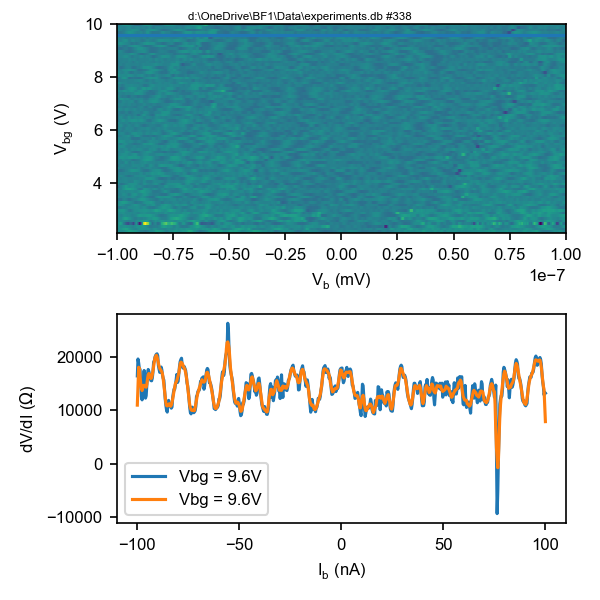

In [399]:
Nsmooth_x = 5 #1 = no smoothing
Nsmooth_y = 3
#pd.rolling_mean(x, N)[N-1:]

dvdi_smooth = np.ones(np.shape(dvdi))
for i in range(n_lines):
    dvdi_smooth[i,:] = smooth(dvdi[i,:], Nsmooth_x)
    
dvdi_smoothy = np.ones(np.shape(dvdi))
for i in range(Ibias.size):
    dvdi_smoothy[:,i] = smooth(dvdi_smooth[:,i], Nsmooth_y)


fig = plt.figure(figsize=(4,4))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
#ax3 = plt.subplot(224)

bg_cut = 9.625
bg_cut_idx = np.argmin(abs(bg - bg_cut))
bg_cut = bg[bg_cut_idx]

p = ax1.pcolor(Ibias, bg[0:n_lines], dvdi_smooth)
ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{V_{bg}}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")


ax2.plot(Ibias/1e-9, dvdi[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.plot(Ibias/1e-9, dvdi_smooth[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
ax2.set_ylabel(r'dV/dI ($\Omega$)')
ax2.set_xlabel(r"$\mathregular{I_b}$ (nA)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

#ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
#ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
#ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

In [500]:
dv1 = qc.load_by_id(345)
dv1

results #345@d:/OneDrive/BF1/Data/experiments.db
------------------------------------------------
ivvi_setup_dac4 - numeric
AMI430_field - numeric
ivvi_setup_v1_measurement - numeric
ivvi_setup_v2_measurement - numeric
ivvi_setup_r_ac1_measurement - numeric
ivvi_setup_r_ac2_measurement - numeric

<IPython.core.display.Javascript object>


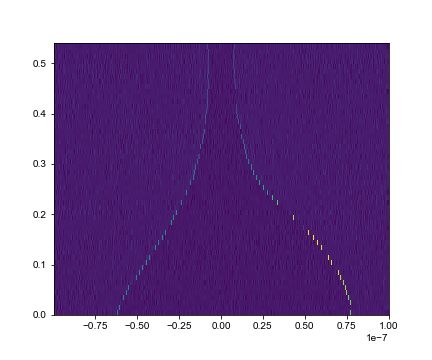

In [519]:
field = np.array(dv1.get_data("AMI430_field"))[:,0] 
Ibias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
v     = np.array(dv1.get_values('ivvi_setup_v2_measurement'))[:,0]
dvdi  = np.array(dv1.get_values('ivvi_setup_r_ac2_measurement'))[:,0]



field = np.unique(field)
# bg = np.flip(bg, 0)
Ibias= np.unique(Ibias)

n_lines = field.size
n_lines = 55
v = v[0:n_lines*Ibias.size]

v = v.reshape(n_lines, Ibias.size)

# y_cut = 21
# y_cut_idx = np.argmin(abs(field - y_cut))
# y_cut = field[y_cut_idx]

fig, ax1 = plt.subplots(1,1, figsize=(6,5))

# ax2 = plt.subplot(223)
# ax3 = plt.subplot(224)

ax1.pcolor(Ibias[1::], field[0:n_lines], np.diff(v,1))
# ax1.axhline(y=y_cut)


# bg_cut = -12
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40

<IPython.core.display.Javascript object>


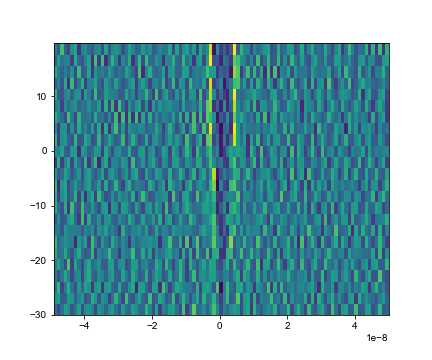

In [494]:
theta = np.array(dv1.get_data("AMI430_theta"))[:,0] 
Ibias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
v     = np.array(dv1.get_values('ivvi_setup_v1_measurement'))[:,0]
dvdi  = np.array(dv1.get_values('ivvi_setup_r_ac1_measurement'))[:,0]



theta = np.unique(theta)
# bg = np.flip(bg, 0)
Ibias= np.unique(Ibias)

# n_lines = theta.size
# n_lines = 3
v = v[0:n_lines*Ibias.size]

v = v.reshape(n_lines, Ibias.size)

fig, ax1 = plt.subplots(1,1, figsize=(6,5))

ax1.pcolor(Ibias[1::], theta[0:n_lines], np.diff(v,1))

# bg_cut = -12
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40

## scribbles

In [ ]:
pt1 = [0.5, 0.6]
pt2 = [1.2, -1]

<IPython.core.display.Javascript object>


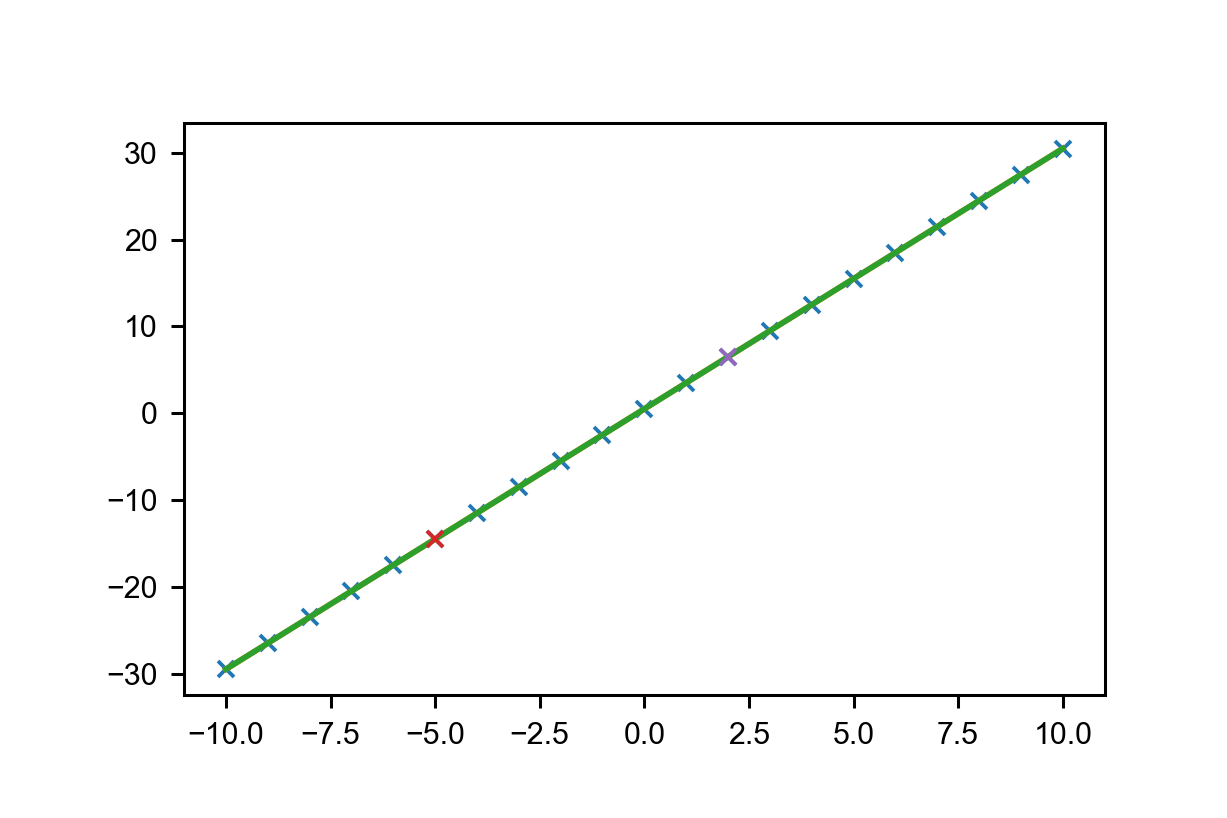

In [183]:
m = 3
b = 0.5
x = np.linspace(-10,10,21)
y = m*x + b


pt1 = [5,15.5]
pt2 = [-8, -23.5]
m2 = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
b2 = -m2*pt1[0] + pt1[1]
y2 = m2*x + b2

plt.plot(x,y,'x')
plt.plot(x,y2)
plt.show()

In [185]:
def smartgate(pt1, pt2, x1, x2):
    m = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
    b = -m*pt1[0] + pt1[1]
    
    y1 = x1*m + b
    y2 = x2*m + b
    return y1, y2

<IPython.core.display.Javascript object>


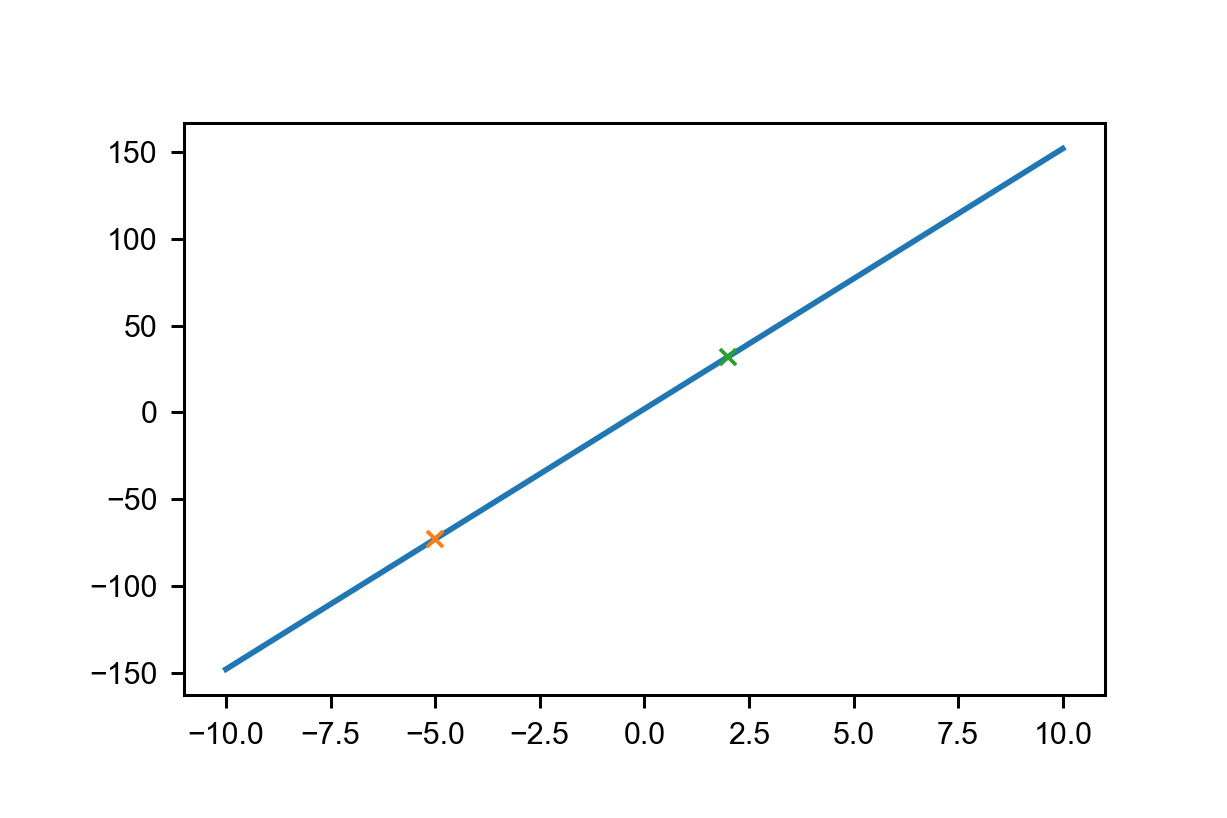

In [190]:
m = 15
b = 2
x = np.linspace(-10,10,21)
y = m*x + b

idx1 = 5
idx2 = 12
pt1 = [x[idx1], y[idx1]]
pt2 = [x[idx2], y[idx2]]

y1,y2 = smartgate(pt1, pt2, x[idx1], x[idx2])
plt.plot(x,y)
plt.plot(x[idx1], y1, 'x')
plt.plot(x[idx2], y2, 'x')
plt.show()

In [206]:
def gateslope(pt1, pt2):
    m = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
    
    return m

pt1 = [-969,94.7]
pt2 = [933,-142]

print(gateslope(pt1,pt2))

-0.12444794952681387


In [224]:
#Procedure for using smartgate function to sweep chemical potential: Take cutter vs plunger scan (cutter ~ y, 
#plunger ~ x).  Get slope of dot resonance at two points (pt1 & pt2).  Scan bias vs plunger at some fixed cutter 
#voltage to find desired cotunneling regime (e.g. fix x0 and y0).  Input starting and ending plunger values (x1 & x2)
#Function will output corresponding cutter voltages to keep the dot in the same cotunneling regime
def smartgate2(pt1, pt2, x0, y0, x1, x2):
    m = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
    b = -m*pt1[0] + pt1[1]
    
    b1 = -m*x0 + y0
    y1 = x1*m + b1
    y2 = x2*m + b1
    return y1, y2, m, b1

<IPython.core.display.Javascript object>


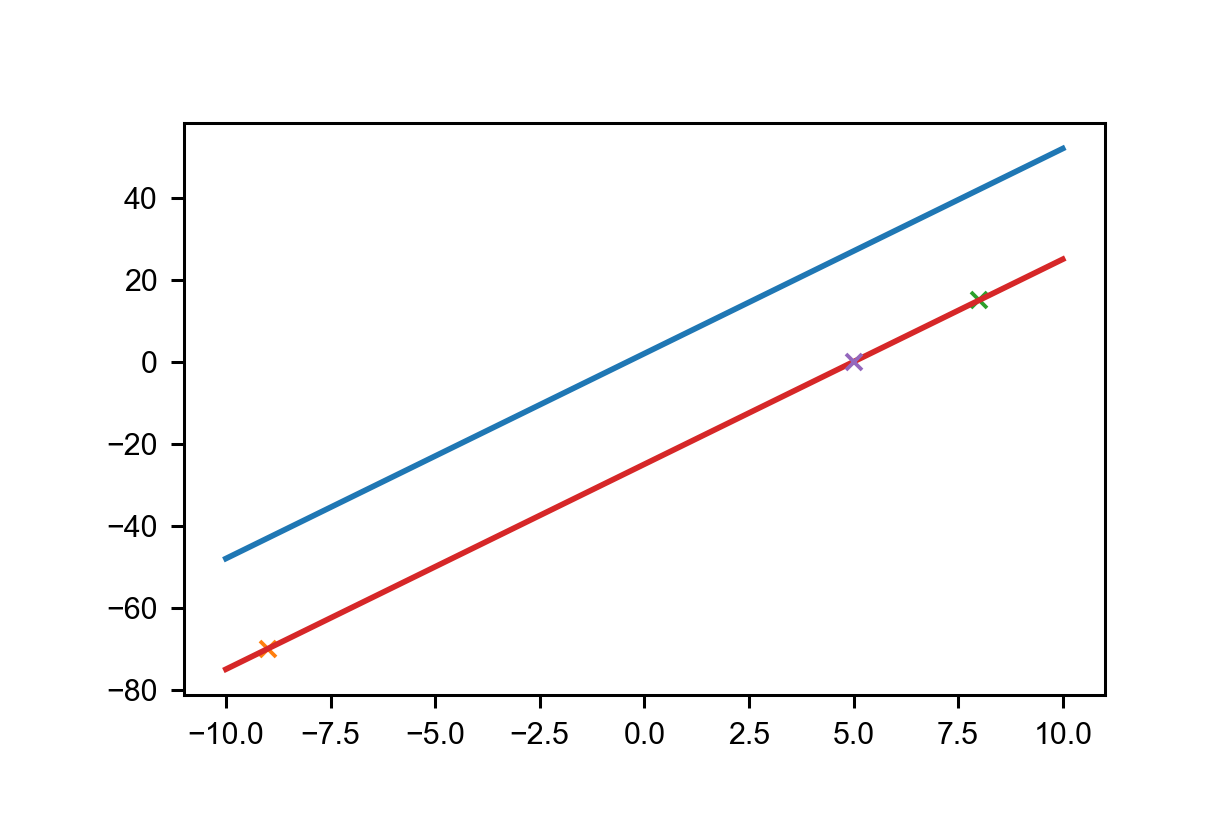

In [228]:
m = 5
b = 2
x = np.linspace(-10,10,21)
y = m*x + b

idx1 = 5
idx2 = 12
pt1 = [x[idx1], y[idx1]]
pt2 = [x[idx2], y[idx2]]
x0 = 5
y0 = 0
x1 = -9
x2 = 8

y1,y2,m,b1 = smartgate2(pt1, pt2, x0, y0, x1, x2)
plt.plot(x,y)
plt.plot(x1, y1, 'x')
plt.plot(x2, y2, 'x')
plt.plot(x, m*x + b1)
plt.plot(x0,y0, 'x')
plt.show()

In [233]:
def Bmax(theta):
    By = 1
    Br = By/np.sin(theta*np.pi/180)
    return Br

print(Bmax(162))

3.2360679775


In [234]:
180*np.arcsin(0.5)/np.pi

30.000000000000004

## Conductance spectroscopy with corrected bias

In [ ]:
Rseries = 10e3


bg = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
bias = np.array(dv1.get_data("ivvi_setup_dac5"))[:,0] 
current = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g1_measurement'))[:,0]

bg = np.unique(bg)
bg = np.flip(bg, 0)
bias= np.unique(bias)


#bias_corrected = 
n_lines = bg.size


g = g.reshape(n_lines, bias.size)
current = current.reshape(n_lines, bias.size)

bias_corrected = np.empty(np.shape(g))
for i in range(np.shape(bias_corrected)[0]):
    for j in range(np.shape(bias_corrected)[1]):
        bias_corrected[i,j] = bias[j] - current[i,j]*Rseries

plt.pcolor(bias_corrected/1e-3, bg, g, cmap='gist_heat')
plt.xlabel('Bias (mV)')
plt.ylabel(r"$\mathregular{V_{bg}}$ (V)")
plt.xlim([np.min(bias)/1e-3,np.max(bias)/1e-3])
plt.colorbar(label=r"dI/dV ($\mathregular{2e^2/h}$) ")
plt.title(ds_title(str(dv1.run_id)), size='small')

In [353]:
1e-6/(2*np.pi*np.sqrt(310e-9*1e-12))

285.85071623074032

In [354]:
248e-9*2048*

0.000507904

## MIDAS power vs frequency

In [367]:
dv1 = qc.load_by_id(137)
dv1

results #137@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
frq - numeric
ivvi_setup_dac3 - numeric
logmag - numeric

In [ ]:
dv1 = qc.load_by_id(146)

frequency = np.array(dv1.get_data("frq"))[:,0] 
attenuation = np.array(dv1.get_data("att"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
S11 = np.array(dv1.get_values('logmag'))[:,0]


# cutter_cut = 0.55
# bg_cut_idx = np.argmin(abs(bg - bg_cut))
# n_cut = 40


#***************************************

frequency = np.unique(frequency)
#bg = np.flip(bg, 0)
attenuation= np.unique(attenuation)
attenuation = np.flip(attenuation,0)

n_lines = attenuation.size - 1
S11 = S11[0:n_lines*frequency.size]

S11 = S11.reshape(n_lines, frequency.size)

fig, ax1 = plt.subplots(1,1, figsize=(5,4))




p = ax1.pcolor(attenuation[0:n_lines], frequency/1e6, S11.transpose())#, vmin=0, vmax=0.03)
#ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"Frequency (MHz)")
ax1.set_xlabel(r"Attenation (dB)")
plt.colorbar(p, ax=ax1, label = r'|S11| (dB)')


# ax2.plot(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
# ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax2.legend()
# # ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

## MIDAS gate vs frequency

In [317]:
dv1 = qc.load_by_id(520)
dv1

results #520@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
hetsrc_frequency - numeric
ivvi_dac7 - numeric
sequence_awg_sweep_idx - numeric
detector_channels - numeric
detector_signal_real - numeric
detector_signal_imag - numeric
detector_signal_abs - numeric
detector_signal_phase - numeric

In [364]:
dv1 = qc.load_by_id(520)

frequency = np.array(dv1.get_data("hetsrc_frequency"))[:,0] 
bias = np.array(dv1.get_data("ivvi_dac7"))[:,0]*5/1e3
#gate = np.array(dv1.get_data("ivvi_setup_dac3"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
S11 = np.array(dv1.get_values('detector_signal_abs'))[:,0]
#phase = np.array(dv1.get_values('phase'))[:,0]
print(np.size(S11))

40602


In [344]:
101*201

20301

In [365]:
S11 = S11.reshape(2,101,201)

In [367]:
np.shape(S11)

(2, 101, 201)

In [370]:
S11=S11[1,:,:]

In [371]:
np.shape(S11)

(101, 201)

In [406]:
dv1 = qc.load_by_id(528)

frequency = np.array(dv1.get_data("hetsrc_frequency"))[:,0] 
bias = np.array(dv1.get_data("ivvi_dac7"))[:,0]*5/1e3
#gate = np.array(dv1.get_data("ivvi_setup_dac3"))[:,0] 
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
S11 = np.array(dv1.get_values('detector_signal_abs'))[:,0]
#phase = np.array(dv1.get_values('phase'))[:,0]
print(np.size(S11))

frequency_cut = 228e6
frequency = np.unique(frequency)
f_cut_idx = np.argmin(abs(frequency - frequency_cut))
# n_cut = 40


#***************************************


#bg = np.flip(bg, 0)
bias = np.unique(bias)
#gate = np.flip(gate,0)

#n_lines = bias.size - 1
#S11 = S11[0:n_lines*frequency.size]
S11 = S11.reshape(len(bias),len(frequency),2)
S11=S11[:,:,1]
#S11 = S11.reshape(n_lines, frequency.size)

#fig = plt.subplots(2,1, figsize=(5,4))
# fig = plt.figure(figsize=(5.5,6))
# ax1 = plt.subplot(111)
# ax2 = plt.subplot(211)
# ax3 = plt.subplot(121)
fig = plt.figure(figsize=(4,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)


p = ax1.pcolor(bias, frequency/1e6, np.transpose(S11), vmin=0, vmax=0.05)
ax1.axhline(y=frequency_cut/1e6, color='red', linestyle='dotted')
ax1.set_ylabel(r"Frequency (MHz)")
ax1.set_xlabel(r"$V_{plunger}$ (V)")
plt.colorbar(p, ax=ax1, label = r'Alazar mag (V)')


ax2.plot(bias, S11[:,f_cut_idx], label='f = ' + str(frequency_cut/1e6) + 'MHz')
ax2.set_ylabel(r'Alazar mag (V)')
ax2.set_xlabel(r'$\mathregular{V_{plunger}}$ (V)')
ax2.legend()
#ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

23898


ValueError: cannot reshape array of size 23898 into shape (60,201,2)

81002


<IPython.core.display.Javascript object>


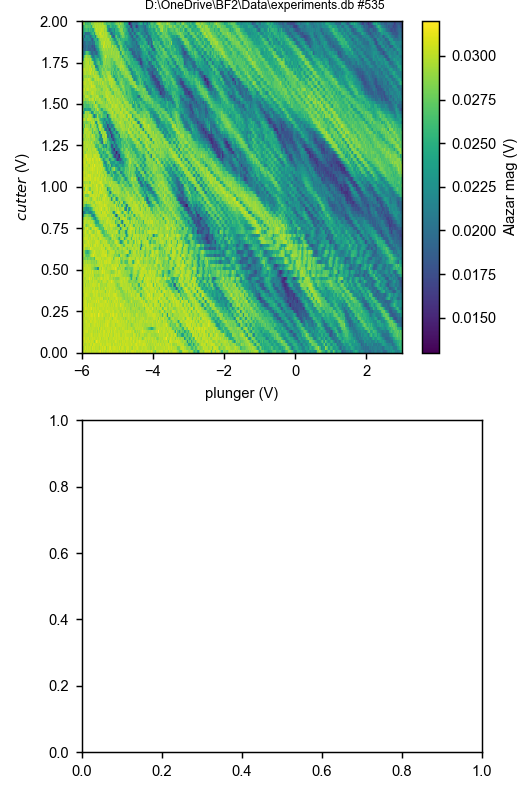

In [430]:
dv1 = qc.load_by_id(535)

#frequency = np.array(dv1.get_data("hetsrc_frequency"))[:,0] 
#bias = np.array(dv1.get_data("awg_ramp_voltages"))*2/1e2*1e3
bias = np.array(dv1.get_data("ivvi_dac7"))*5/1000
gate = np.array(dv1.get_data("ivvi_dac6"))*5/1000
#i = np.array(dv1.get_values('ivvi_setup_i1_measurement'))[:,0]
S11 = np.array(dv1.get_values('detector_signal_abs'))
#phase = np.array(dv1.get_values('phase'))[:,0]
print(np.size(S11))

#frequency_cut = 228e6
#frequency = np.unique(frequency)
#f_cut_idx = np.argmin(abs(frequency - frequency_cut))
# n_cut = 40

bias_cut = 0
bias = np.unique(bias)
f_cut_idx = np.argmin(abs(bias - bias_cut))


#***************************************


#bg = np.flip(bg, 0)

gate = np.unique(gate)
#gate = np.flip(gate,0)

#n_lines = bias.size - 1
#S11 = S11[0:n_lines*frequency.size]
S11 = S11.reshape(len(gate),len(bias),2)
S11=S11[:,:,1]
#S11 = S11.reshape(n_lines, frequency.size)

#fig = plt.subplots(2,1, figsize=(5,4))
# fig = plt.figure(figsize=(5.5,6))
# ax1 = plt.subplot(111)
# ax2 = plt.subplot(211)
# ax3 = plt.subplot(121)
fig = plt.figure(figsize=(4,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)


p = ax1.pcolor(bias, gate, S11, vmin=0.013, vmax=0.032)
#ax1.axhline(y=frequency_cut/1e6, color='red', linestyle='dotted')
ax1.set_xlabel(r"plunger (V)")
ax1.set_ylabel(r"$cutter$ (V)")
plt.colorbar(p, ax=ax1, label = r'Alazar mag (V)')


#ax2.plot(bias, S11[:,f_cut_idx], label='f = ' + str(frequency_cut/1e6) + 'MHz')
#ax2.set_ylabel(r'Alazar mag (V)')
#ax2.set_xlabel(r'$\mathregular{V_{plunger}}$ (V)')
#ax2.legend()
#ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

# ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='Vbg = ' + str(bg_cut) + 'V')
# ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
# ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

In [435]:
14/353793*(401*401*2*101)/60

21.422377303489142

## RF software sweep

In [7]:
dv1 = qc.load_by_id(564)
dv1

results #564@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
yoko_voltage - numeric
ivvi_dac7 - numeric
sequence_awg_sweep_idx - numeric
detector_channels - numeric
detector_signal_real - numeric
detector_signal_imag - numeric
detector_signal_abs - numeric
detector_signal_phase - numeric

In [453]:
np.shape(RF_all)

(20402,)

<IPython.core.display.Javascript object>


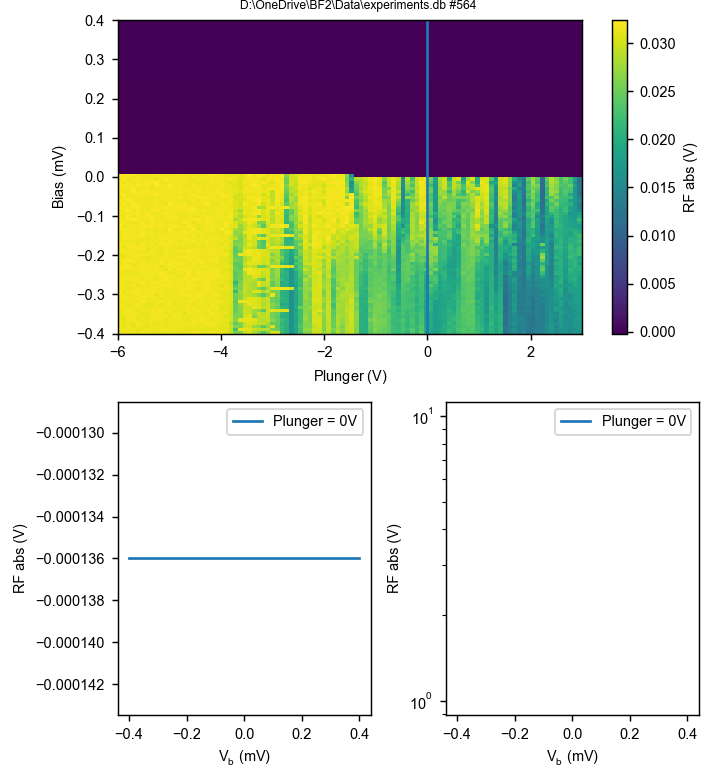

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


In [10]:
dv1 = qc.load_by_id(564)

gate = np.array(dv1.get_data("ivvi_dac7"))[:,0] 
bias = np.array(dv1.get_data("yoko_voltage"))[:,0] 
# i = np.array(dv1.get_values('ivvi_setup_i3_measurement'))[:,0]
RF_all = np.array(dv1.get_values('detector_signal_abs'))[:,0]



gate = np.unique(gate)*5/1000
#bg = np.flip(bg, 0)
bias= np.unique(bias)

n_lines = gate.size 

RF = np.empty(int(len(RF_all)/2))
idx = 0
for i in range(len(RF)):
    if i % 2 == 0:
        RF[idx] = RF_all[i]
        idx = idx + 1


#RF = RF[0:n_lines*gate.size]

RF = RF.reshape(n_lines, bias.size)

fig = plt.figure(figsize=(5.5,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

gate_cut = 0
gate_cut_idx = np.argmin(abs(gate - gate_cut))
n_cut = 40


p = ax1.pcolor(gate, bias[0:n_lines]*1e3, RF)#, vmin=0, vmax=0.25)
ax1.axvline(x=gate_cut)
ax1.set_ylabel(r"$\mathregular{Bias}$ (mV)")
ax1.set_xlabel(r"$\mathregular{Plunger}$ (V)")
plt.colorbar(p, ax=ax1, label = r'RF abs (V)')


ax2.plot(bias*1e3, RF[gate_cut_idx,:], label='Plunger = ' + str(gate_cut) + 'V')
ax2.set_ylabel(r'RF abs (V)')
ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

ax3.semilogy(bias*1e3, RF[gate_cut_idx,:], label='Plunger = ' + str(gate_cut) + 'V')
ax3.set_ylabel(r'RF abs (V)')
ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()


In [38]:
a = np.array([1,2,3,4,5,6])
print(a.shape)
a = a.reshape(2,3)
a

(6,)


array([[1, 2, 3],
       [4, 5, 6]])

(81002, 1) 0.0137376914357 0.0321612606165


<IPython.core.display.Javascript object>


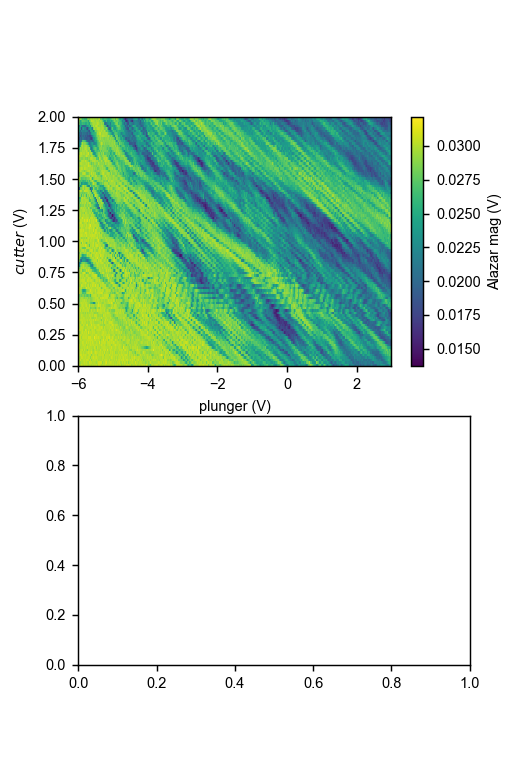

In [102]:
dv1 = qc.load_by_id(535)

#inner_1 = np.array(dv1.get_data("awg_ramp_voltages"))*5/1000
inner_2 = np.unique(np.array(dv1.get_data("ivvi_dac7"))*5/1000)
inner_3 = np.unique(np.array(dv1.get_data("ivvi_dac6"))*5/1000)

y = np.array(dv1.get_values('detector_signal_abs'))
min_y = min(np.unique(y))
max_y = max(np.unique(y))
print(y.shape, min_y, max_y)

y = y.reshape(len(inner_3), len(inner_2), 2)
y = y[:,:,1]

fig = plt.figure(figsize=(4,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)


p = ax1.pcolor(inner_2, inner_3, y, vmin=min_y, vmax=max_y)
#ax1.axhline(y=frequency_cut/1e6, color='red', linestyle='dotted')
ax1.set_xlabel(r"plunger (V)")
ax1.set_ylabel(r"$cutter$ (V)")
plt.colorbar(p, ax=ax1, label = r'Alazar mag (V)')

## Better functions for reshaping and visualization

In [7]:
def find_nearest(array, value):
    idx_closest = np.argmin(abs(array - value))
    return idx_closest

In [8]:
def return_idx_array(array, value_array):
    idx = []
    for k in range(np.size(value_array)):
        idx.append(find_nearest(array,value_array[k]))
    return idx

In [13]:
def f3Dt2D(dat,l1,l2,s):
    i1 = np.unique(np.array(dat.get_data(l1))*2/100)
    i2 = np.unique(np.array(dat.get_data(l2))*5/1000) #plunger

    y = np.array(dat.get_data(s))
    
    p = y.reshape(len(i2), len(i1), 2)
    
    yp = p[:,:,1]
    
    min_y = min(np.unique(yp))
    max_y = max(np.unique(yp))
    
    fig = plt.figure(figsize=(4,6))
    ax1 = plt.subplot(111)
    
    pl = ax1.pcolor(i1, i2, yp, vmin=min_y, vmax=max_y)
    ax1.set_xlabel(r"bias (V)")
    ax1.set_ylabel(r"$plunger$ (V)")
    plt.colorbar(pl, ax=ax1, label = r'Alazar mag (V)')

In [14]:
def f2Dt1D(dat,l1,l2,s,i1_values,i2_values):
    i1 = np.unique(np.array(dat.get_data(l1))*2/100)
    i2 = np.unique(np.array(dat.get_data(l2))*5/1000) #plunger

    y = np.array(dat.get_data(s))
    
    p = y.reshape(len(i2), len(i1), 2)
    print(len(i2), len(i2_values),len(return_idx_array(i2,i2_values)))
    yp = p[return_idx_array(i2,i2_values),return_idx_array(i1,i1_values),1]
    
    plt.figure()
    if i1_values.size > 1:        
        plt.plot(i1_values,yp)
        plt.xlabel('Bias (V)')
        plt.ylabel(r"Alazar mag (V)")
    else:
        plt.plot(i2_values,yp)
        plt.xlabel('Plunger (V)')
        plt.ylabel(r"Alazar mag (V)")

## From 3D to 2D and 1D plotting

In [15]:
dv = qc.load_by_id(592)

<IPython.core.display.Javascript object>


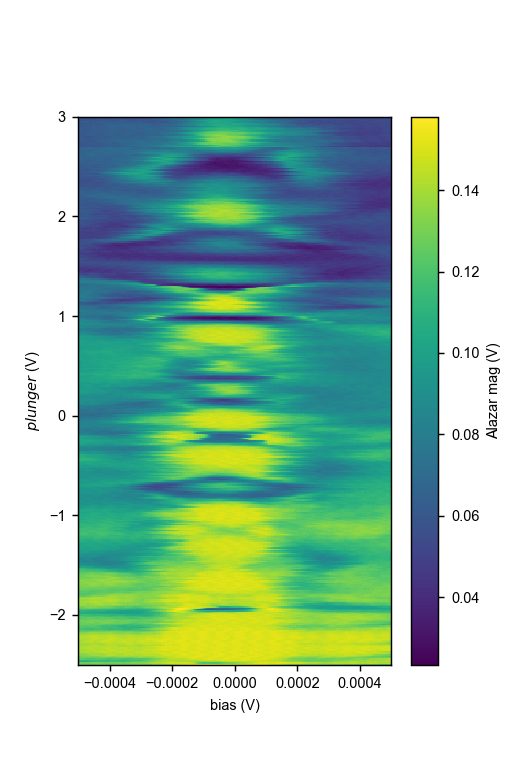

In [16]:
f3Dt2D(dv, "awg_ramp_voltages", "ivvi_dac7", 'detector_signal_abs')

401 101 101


<IPython.core.display.Javascript object>


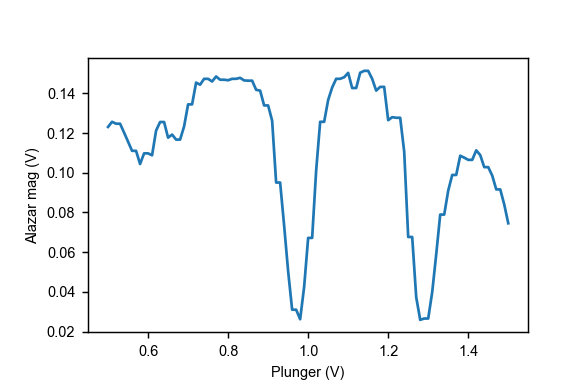

In [17]:
vals = np.linspace(0.5,1.5,101)
f2Dt1D(dv, "awg_ramp_voltages", "ivvi_dac7", 'detector_signal_abs', np.array([0]), vals)

## Phase diagrams data analysis

In [486]:
dv1 = qc.load_by_id(606)

inner_1_606 = np.unique(np.array(dv1.get_data("awg_ramp_voltages"))*2/100)
inner_2_606 = np.unique(np.array(dv1.get_data("ivvi_dac7"))*5/1000) #plunger
inner_3_606 = np.unique(np.array(dv1.get_data("ivvi_dac6"))*5/1000) #cutter

y_606 = np.array(dv1.get_values('detector_signal_abs'))

In [487]:
dv1 = qc.load_by_id(607)

inner_1_607 = np.unique(np.array(dv1.get_data("awg_ramp_voltages"))*2/100)
inner_2_607 = np.unique(np.array(dv1.get_data("ivvi_dac7"))*5/1000) #plunger
inner_3_607 = np.unique(np.array(dv1.get_data("ivvi_dac6"))*5/1000) #cutter

y_607 = np.array(dv1.get_values('detector_signal_abs'))

In [488]:
dv1 = qc.load_by_id(608)

inner_1_608 = np.unique(np.array(dv1.get_data("awg_ramp_voltages"))*2/100)
inner_2_608 = np.unique(np.array(dv1.get_data("ivvi_dac7"))*5/1000) #plunger
inner_3_608 = np.unique(np.array(dv1.get_data("ivvi_dac6"))*5/1000) #cutter

y_608 = np.array(dv1.get_values('detector_signal_abs'))

In [489]:
dv1 = qc.load_by_id(609)

inner_1_609 = np.unique(np.array(dv1.get_data("awg_ramp_voltages"))*2/100)
inner_2_609 = np.unique(np.array(dv1.get_data("ivvi_dac7"))*5/1000) #plunger
inner_3_609 = np.unique(np.array(dv1.get_data("ivvi_dac6"))*5/1000) #cutter

y_609 = np.array(dv1.get_values('detector_signal_abs'))

In [18]:
t0 = time.clock()
dv1 = qc.load_by_id(605)

inner_1 = np.unique(np.array(dv1.get_data("awg_ramp_voltages"))*2/100)
inner_2 = np.unique(np.array(dv1.get_data("ivvi_dac7"))*5/1000) #plunger
inner_3 = np.unique(np.array(dv1.get_data("ivvi_dac6"))*5/1000) #cutter

y = np.array(dv1.get_data('detector_signal_abs'))
print((time.clock()-t0)/60, 'min')

5.780518194858861 min


In [19]:
print('min inner_1 =', min(inner_1),'\nmax inner_1 =', max(inner_1))
print('\nmin inner_2 =', min(inner_2),'\nmax inner_2 =', max(inner_2))
print('\nmin inner_3 =', min(inner_3),'\nmax inner_3 =', max(inner_3))

min inner_1 = -0.0005 
max inner_1 = 0.0005

min inner_2 = -6.0 
max inner_2 = 0.999923704891

min inner_3 = 0.000152590218967 
max inner_3 = 2.0


### First cut for 2D plot

#### Bias vs plunger
Change cutter as value_1

0.000152590218967


<IPython.core.display.Javascript object>


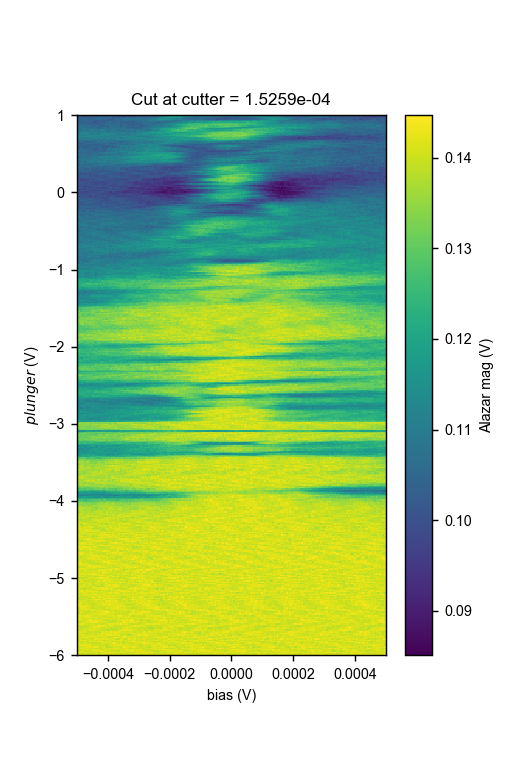

In [490]:
loop_1 = inner_3
value_1 = 0

idx_1 = find_nearest(loop_1,value_1) #choose loop and value and insert below
print(loop_1[idx_1])

y_p = y.reshape(len(inner_3), len(inner_2), len(inner_1), 2)

y_plot = y_p[idx_1,:,:,1]

min_y = min(np.unique(y_plot))
max_y = max(np.unique(y_plot))

fig = plt.figure(figsize=(4,6))

ax1 = plt.subplot(111)
#ax2 = plt.subplot(212)


p = ax1.pcolor(inner_1, inner_2, y_plot, vmin=min_y, vmax=max_y)
#ax1.axhline(y=frequency_cut/1e6, color='red', linestyle='dotted')
ax1.set_xlabel(r"bias (V)")
ax1.set_ylabel(r"$plunger$ (V)")
ax1.set_title('Cut at cutter = {:.4e}'.format(loop_1[idx_1]))
plt.colorbar(p, ax=ax1, label = r'Alazar mag (V)')

#### Bias vs cutter
Change plunger as value_1

-1.99237048905


<IPython.core.display.Javascript object>


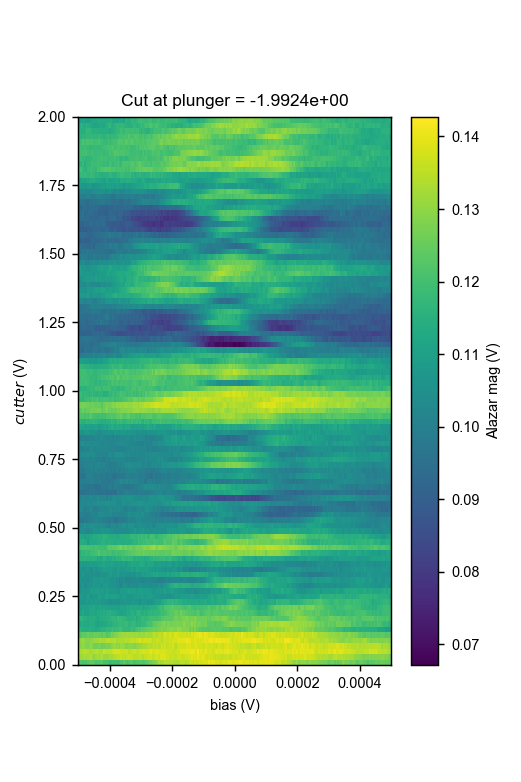

In [336]:
loop_1 = inner_2
value_1 = -2

idx_1 = find_nearest(loop_1,value_1) #choose loop and value and insert below
print(loop_1[idx_1])

y_p = y.reshape(len(inner_3), len(inner_2), len(inner_1), 2)

y_plot = y_p[:,idx_1,:,1]

min_y = min(np.unique(y_plot))
max_y = max(np.unique(y_plot))

fig = plt.figure(figsize=(4,6))

ax1 = plt.subplot(111)
#ax2 = plt.subplot(212)


p = ax1.pcolor(inner_1, inner_3, y_plot, vmin=min_y, vmax=max_y)
#ax1.axhline(y=frequency_cut/1e6, color='red', linestyle='dotted')
ax1.set_xlabel(r"bias (V)")
ax1.set_ylabel(r"$cutter$ (V)")
ax1.set_title('Cut at plunger = {:.4e}'.format(loop_1[idx_1]))
plt.colorbar(p, ax=ax1, label = r'Alazar mag (V)')

#### plunger vs cutter plot
Change bias as value_1

-2.51256281407e-06


<IPython.core.display.Javascript object>


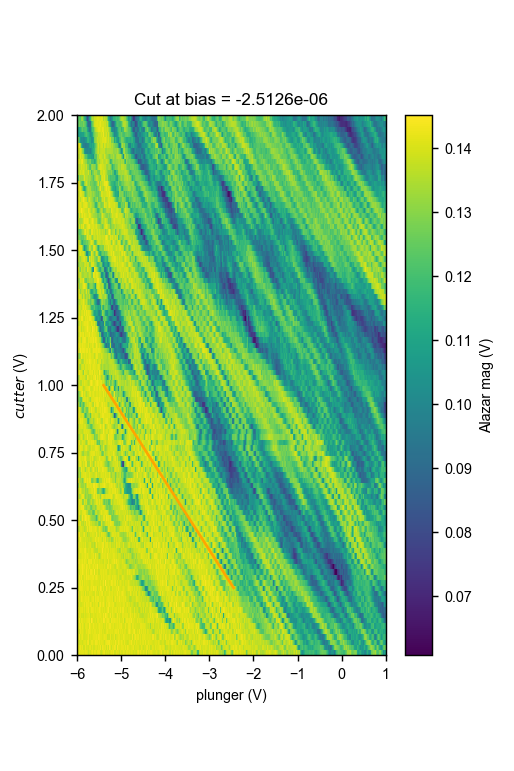

In [371]:
loop_1 = inner_1
value_1 = 0

idx_1 = find_nearest(loop_1,value_1) #choose loop and value and insert below
print(loop_1[idx_1])

y_p = y.reshape(len(inner_3), len(inner_2), len(inner_1), 2)

y_plot = y_p[:,:,idx_1,1]

min_y = min(np.unique(y_plot))
max_y = max(np.unique(y_plot))

fig = plt.figure(figsize=(4,6))

ax1 = plt.subplot(111)
#ax2 = plt.subplot(212)


p = ax1.pcolor(inner_2, inner_3, y_plot, vmin=min_y, vmax=max_y)
#ax1.axhline(y=frequency_cut/1e6, color='red', linestyle='dotted')
ax1.set_xlabel(r"plunger (V)")
ax1.set_ylabel(r"$cutter$ (V)")
ax1.set_title('Cut at bias = {:.4e}'.format(loop_1[idx_1]))
plt.colorbar(p, ax=ax1, label = r'Alazar mag (V)')

#### Chemical potential cuts

In [372]:
c1 = 1
c2 = 0.25
p1 = -5.4
p2 = -2.45

p = np.linspace(p1,p2,101)
c = np.linspace(c1,c2,101)
plt.plot(p,c, color='orange')
#ax1.axhline(y, color='red', linestyle='dotted')

In [365]:
np.size(inner_2)

401

##### Version 1

In [344]:
for i in range(np.size(p)):
    y2plot = np.empty([np.size(p), np.size(inner_1)])
    y2plot[i,:] = y_p[find_nearest(inner_3,c[i]), find_nearest(inner_2,p[i]),:,1]
    



<IPython.core.display.Javascript object>


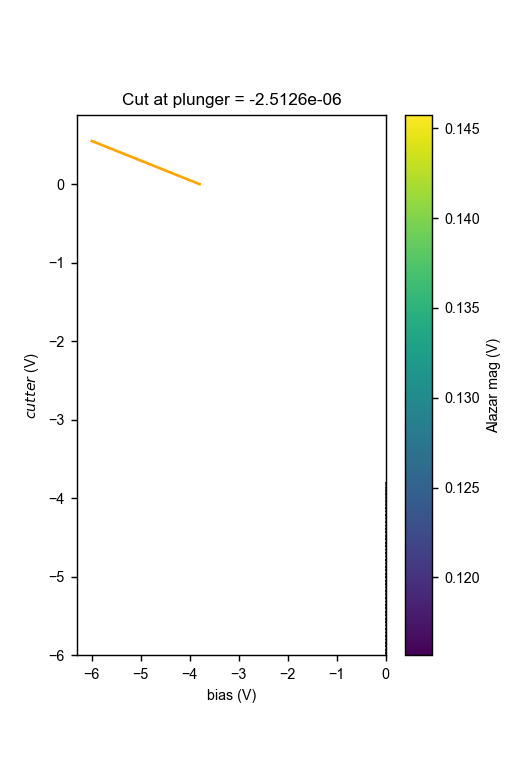

In [345]:
fig = plt.figure(figsize=(4,6))

ax1 = plt.subplot(111)
#ax2 = plt.subplot(212)


p = ax1.pcolor(inner_1, p, y2plot, vmin=min_y, vmax=max_y)
#ax1.axhline(y=frequency_cut/1e6, color='red', linestyle='dotted')
ax1.set_xlabel(r"bias (V)")
ax1.set_ylabel(r"$cutter$ (V)")
ax1.set_title('Cut at plunger = {:.4e}'.format(loop_1[idx_1]))
plt.colorbar(p, ax=ax1, label = r'Alazar mag (V)')

##### Version 2 (better?)

<IPython.core.display.Javascript object>


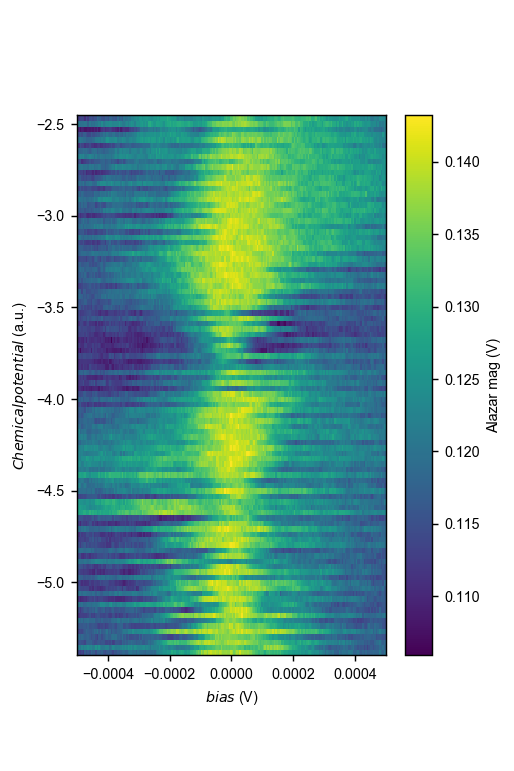

In [373]:
y_plot = y_p[return_idx_array(inner_3,c),return_idx_array(inner_2,p),:,1]

min_y = min(np.unique(y_plot))
max_y = max(np.unique(y_plot))

fig = plt.figure(figsize=(4,6))

ax2 = plt.subplot(111)
#ax2 = plt.subplot(212)


p = ax2.pcolor(inner_1, p, y_plot, vmin=min_y, vmax=max_y)
#ax1.axhline(y=frequency_cut/1e6, color='red', linestyle='dotted')
ax2.set_xlabel(r"$bias$ (V)")
ax2.set_ylabel(r"$Chemical potential$ (a.u.)")
#ax2.set_title('Cut at plunger = {:.4e}'.format(loop_1[idx_1]))
plt.colorbar(p, ax=ax2, label = r'Alazar mag (V)')

### 2nd cut for 1D plot

In [127]:
loop_1 = inner_1
value_1 = 1e-4

idx_1 = find_nearest(loop_1,value_1) #choose loop and value and insert below
print('check 1st cut value:',loop_1[idx_1])

loop_2 = inner_3
value_2 = 2

idx_2 = find_nearest(loop_2,value_2) #choose loop and value and insert below
print('check 2nd cut value:', loop_2[idx_2])

y_plot = y_p[idx_2,:,idx_1,1] #insert idx on the desired dimension

min_y = min(np.unique(y_plot))
max_y = max(np.unique(y_plot))
print(min_y, max_y)

check 1st cut value: 9.79899497487e-05
check 2nd cut value: 0.999923704891
0.076841047604 0.110014730995


<IPython.core.display.Javascript object>


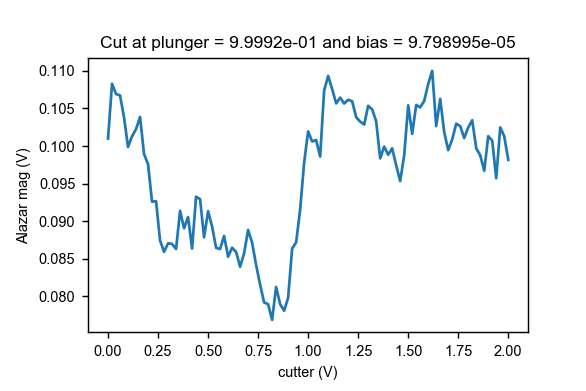

Text(0.5,1,'Cut at plunger = 9.9992e-01 and bias = 9.798995e-05')

In [138]:
plt.figure()
plt.plot(inner_2, y_plot)
plt.xlabel('cutter (V)')
plt.ylabel('Alazar mag (V)')
plt.title('Cut at plunger = {:.4e} and bias = {:.6e}'.format(loop_2[idx_2],loop_1[idx_1]))

### Else

81002


<IPython.core.display.Javascript object>


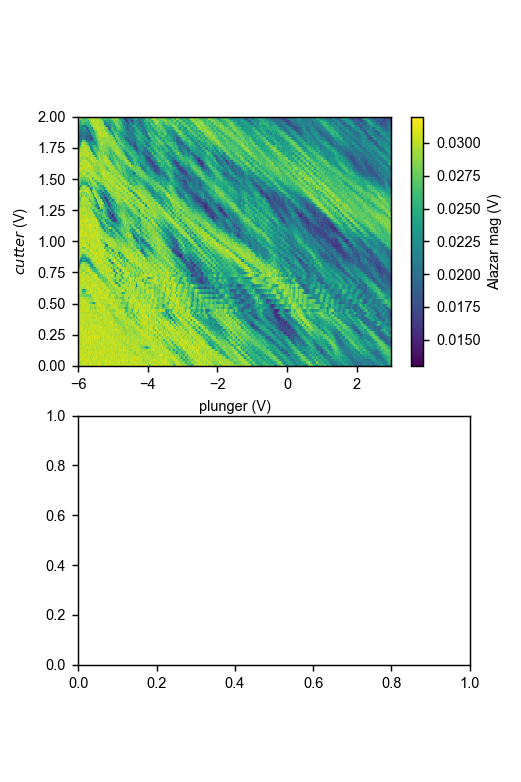

In [11]:
dv1 = qc.load_by_id(535)

bias = np.array(dv1.get_data("ivvi_dac7"))*5/1000
gate = np.array(dv1.get_data("ivvi_dac6"))*5/1000
S11 = np.array(dv1.get_values('detector_signal_abs'))

print(np.size(S11))

#frequency_cut = 228e6
#frequency = np.unique(frequency)
#f_cut_idx = np.argmin(abs(frequency - frequency_cut))
# n_cut = 40

bias_cut = 0
bias = np.unique(bias)
f_cut_idx = np.argmin(abs(bias - bias_cut))


#***************************************


#bg = np.flip(bg, 0)

gate = np.unique(gate)
#gate = np.flip(gate,0)

#n_lines = bias.size - 1
#S11 = S11[0:n_lines*frequency.size]
S11 = S11.reshape(len(gate),len(bias),2)
S11=S11[:,:,1]
#S11 = S11.reshape(n_lines, frequency.size)

#fig = plt.subplots(2,1, figsize=(5,4))
# fig = plt.figure(figsize=(5.5,6))
# ax1 = plt.subplot(111)
# ax2 = plt.subplot(211)
# ax3 = plt.subplot(121)
fig = plt.figure(figsize=(4,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)


p = ax1.pcolor(bias, gate, S11, vmin=0.013, vmax=0.032)
#ax1.axhline(y=frequency_cut/1e6, color='red', linestyle='dotted')
ax1.set_xlabel(r"plunger (V)")
ax1.set_ylabel(r"$cutter$ (V)")
plt.colorbar(p, ax=ax1, label = r'Alazar mag (V)')

## Hardware sweep bias vs frequency

In [60]:
dv1 = qc.load_by_id(283)
dv1

results #283@D:\OneDrive\BF2\Data\experiments.db
------------------------------------------------
v_g - numeric
i_avg - numeric
lockin1_frequency - numeric
v_sd_1 - numeric
v_sd_2 - numeric
v_sd_3 - numeric

<IPython.core.display.Javascript object>


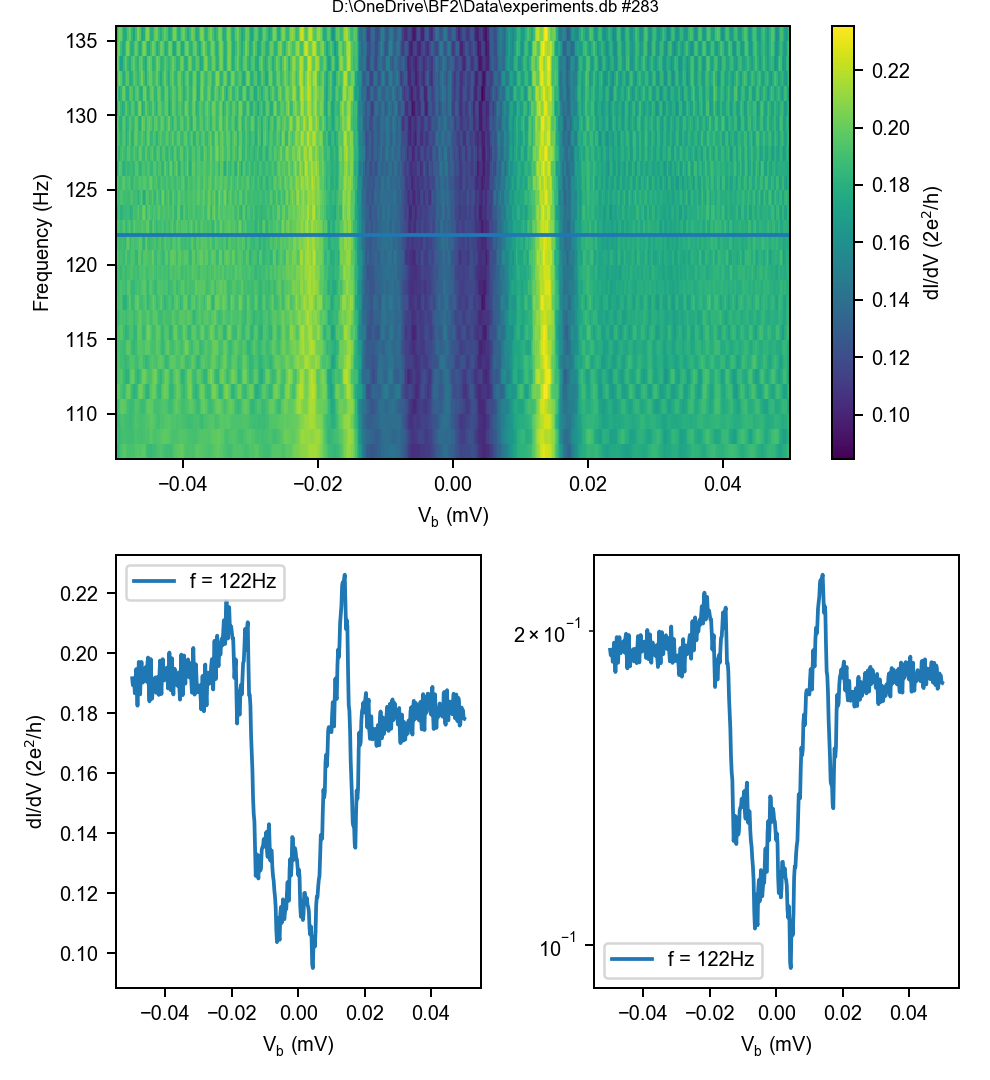

In [66]:
dv1 = qc.load_by_id(283)

f = np.array(dv1.get_data("lockin1_frequency"))[:,0] 
bias = np.array(dv1.get_data("v_g"))[:,0] 
# i = np.array(dv1.get_values('ivvi_setup_i3_measurement'))[:,0]
g = np.array(dv1.get_values('v_sd_1'))[:,0]



f = np.unique(f)
#bg = np.flip(bg, 0)
bias= 2*np.unique(bias)/1000

n_lines = f.size - 1
g = g[0:n_lines*bias.size]

g = g.reshape(n_lines, bias.size)
g = g - .0003

fig = plt.figure(figsize=(5.5,6))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

f_cut = 122
f_cut_idx = np.argmin(abs(f - f_cut))
n_cut = 40


p = ax1.pcolor(bias*1e3, f[0:n_lines], g)#, vmin=0, vmax=0.25)
ax1.axhline(y=f_cut)
ax1.set_ylabel(r"$\mathregular{Frequency}$ (Hz)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")
plt.colorbar(p, ax=ax1, label = r'dI/dV (2e$^2$/h)')


ax2.plot(bias*1e3, g[f_cut_idx,:], label='f = ' + str(f_cut) + 'Hz')
ax2.set_ylabel(r'dI/dV (2e$^2$/h)')
ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax2.legend()
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

ax3.semilogy(bias*1e3, g[f_cut_idx,:], label='f = ' + str(f_cut) + 'Hz')
ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax3.legend()

fig.suptitle(ds_title(str(dv1.run_id)), size='small', y=1)
fig.tight_layout()

# fig.savefig("d:/data/images/gap_dev14.png", dpi=300)